# 1 Data import and pre-pocsssing

In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap
import pandas as pd
import numpy as np
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt
import random
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

import seaborn as sns
from pdpbox import pdp, get_dataset,info_plots
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

from sklearn.inspection import permutation_importance
from alibi.explainers import ALE, plot_ale
from pycebox.ice import ice, ice_plot
# print the JS visualization code to the notebook
shap.initjs()

In [2]:
dtypes = [
    ("QD-source", "category"), ("Core", "category"), ("Shell", "category"),
    ("QD-diameter-nm", "float32"), ("Surface-ligand", "category"), ("Surface-charge", "category"),
    ("Surface-modification", "category"), ("Cell-anatomical-type", "category"), ("Cell-source-species", "category"),
    ("Cell-origin", "category"), ("Assay-type", "category"), ("Delivery-type", "category"),
    ("Exposure-time-hrs", "float32"), ("IC50-mgL-1", "float32")
]
raw_data = pd.read_excel("data_IC50.xlsx",
    names=[d[0] for d in dtypes],
    dtype=dict(dtypes)
)


raw_data['IC50-log-mgL-1'] = np.log10(raw_data['IC50-mgL-1'].values)
del raw_data['IC50-mgL-1']  

raw_data

QD-source  Core     Shell  QD-diameter-nm       Surface-ligand  \
0      In-house  CdSe  No-shell            3.37           Alkylthiol   
1      In-house  CdSe  No-shell            3.37           Alkylthiol   
2      In-house  CdSe  No-shell            4.98           Alkylthiol   
3      In-house  CdSe  No-shell            9.48           Alkylthiol   
4    Commercial  CdSe       ZnS            9.00  Amphiphilic-polymer   
..          ...   ...       ...             ...                  ...   
509    In-house  CdTe       CdS            3.90           Alkylthiol   
510    In-house  CdSe       ZnS            5.50           Alkylthiol   
511    In-house  CdSe       ZnS            5.50           Alkylthiol   
512    In-house  CdSe       CdS            4.30  Hydrophilic-Polymer   
513    In-house  CdSe       CdS            4.30  Hydrophilic-Polymer   

    Surface-charge Surface-modification Cell-anatomical-type  \
0         Negative           Unmodified           Epithelial   
1          Neutral           Unmodified           Epithelial   
2          Neutral           Unmodified           Epithelial   
3          Neutral           Unmodified           Epithelial   
4         Negative           Unmodified           Epithelial   
..             ...                  ...                  ...   
509       Negative          Nucleicacid           Epithelial   
510       Negative           Unmodified           Epithelial   
511       Negative           Unmodified           Fibroblast   
512       Negative           Unmodified           Epithelial   
513       Negative           Unmodified           Epithelial   

    Cell-source-species Cell-origin Assay-type Delivery-type  \
0                Human      Primary        WST       Passive   
1                Human      Primary        WST       Passive   
2                Human      Primary        WST       Passive   
3                Human      Primary        WST       Passive   
4                Human    Cell-line        MTT       Passive   
..                  ...         ...        ...           ...   
509              Human    Cell-line        MTT        Active   
510              Human    Cell-line        MTS       Passive   
511              Human      Primary        MTS       Passive   
512             Hamster   Cell-line        MTT       Passive   
513             Hamster   Cell-line        MTT       Passive   

     Exposure-time-hrs  IC50-log-mgL-1  
0                 22.0        1.653213  
1                 22.0        0.397940  
2                 22.0       -0.154902  
3                 22.0        0.477121  
4                 24.0        1.276378  
..                 ...             ...  
509               24.0        2.392680  
510               48.0        1.954242  
511               48.0        1.954242  
512               24.0        1.301030  
513               48.0        1.096910  

[514 rows x 14 columns]

In [3]:
raw_data.loc[:,'Assay-type'].value_counts()

MTT                            355
MTS                             45
CCK8                            27
WST                             20
Crystal-Violet                  11
Hoechst-staining                11
FACS                             9
Alamar-blue                      8
Others                           7
Luciferase-assay                 4
RT-CES                           3
Resazurin                        3
SRB                              3
live/dead-staining               2
Proliferation                    2
BrdU-TUNEL                       2
Fluorescein-retention-assay      1
methylene-blue                   1
Name: Assay-type, dtype: int64

In [4]:
filt_dtypes = list(filter(lambda x: not (x[0] in ["IC50-log-mgL-1"]), dtypes))
filt_dtypes

[('QD-source', 'category'),
 ('Core', 'category'),
 ('Shell', 'category'),
 ('QD-diameter-nm', 'float32'),
 ('Surface-ligand', 'category'),
 ('Surface-charge', 'category'),
 ('Surface-modification', 'category'),
 ('Cell-anatomical-type', 'category'),
 ('Cell-source-species', 'category'),
 ('Cell-origin', 'category'),
 ('Assay-type', 'category'),
 ('Delivery-type', 'category'),
 ('Exposure-time-hrs', 'float32'),
 ('IC50-mgL-1', 'float32')]

In [5]:
data = raw_data.copy()
for k, dtype in filt_dtypes:
    if dtype == "category":
        data[k] = data[k].cat.codes
data

QD-source  Core  Shell  QD-diameter-nm  Surface-ligand  Surface-charge  \
0            1     2      4            3.37               0               0   
1            1     2      4            3.37               0               1   
2            1     2      4            4.98               0               1   
3            1     2      4            9.48               0               1   
4            0     2      5            9.00               5               0   
..         ...   ...    ...             ...             ...             ...   
509          1     4      0            3.90               0               0   
510          1     2      5            5.50               0               0   
511          1     2      5            5.50               0               0   
512          1     2      0            4.30               6               0   
513          1     2      0            4.30               6               0   

     Surface-modification  Cell-anatomical-type  Cell-source-species  \
0                      10                     1                    4   
1                      10                     1                    4   
2                      10                     1                    4   
3                      10                     1                    4   
4                      10                     1                    4   
..                    ...                   ...                  ...   
509                     5                     1                    4   
510                    10                     1                    4   
511                    10                     2                    4   
512                    10                     1                    3   
513                    10                     1                    3   

     Cell-origin  Assay-type  Delivery-type  Exposure-time-hrs  IC50-log-mgL-1  
0              1          15              1               22.0        1.653213  
1              1          15              1               22.0        0.397940  
2              1          15              1               22.0       -0.154902  
3              1          15              1               22.0        0.477121  
4              0           9              1               24.0        1.276378  
..           ...         ...            ...                ...             ...  
509            0           9              0               24.0        2.392680  
510            0           8              1               48.0        1.954242  
511            1           8              1               48.0        1.954242  
512            0           9              1               24.0        1.301030  
513            0           9              1               48.0        1.096910  

[514 rows x 14 columns]

In [6]:
# 保证结果的复现，保存生成的随机数
#random_index = random.sample(range(0, len(data)), len(data))
#np.save('random_index.npy',random_index)
random_index = np.load('random_index.npy')
random_index[0:10]

array([242, 315, 101, 277, 467, 490, 112, 153, 383,  43])

In [7]:
data_random = data.iloc[random_index]
data_random.head(5)

QD-source  Core  Shell  QD-diameter-nm  Surface-ligand  Surface-charge  \
242          1     2      6             4.0              11               3   
315          1     4      4             3.3               2               3   
101          0     4      0             5.0               6               0   
277          1     4      8             4.8               0               0   
467          1     2      5             5.0               0               0   

     Surface-modification  Cell-anatomical-type  Cell-source-species  \
242                     6                     0                    4   
315                     6                     1                    4   
101                    10                     1                    4   
277                     9                     2                    6   
467                    10                    12                   11   

     Cell-origin  Assay-type  Delivery-type  Exposure-time-hrs  IC50-log-mgL-1  
242            0           9              0               24.0        2.301030  
315            0           9              0               12.0        3.475473  
101            0           9              1               12.0        1.568202  
277            0           9              0               24.0        2.301030  
467            1           9              1               24.0        0.954243

In [8]:
X = data_random.drop(['IC50-log-mgL-1'], axis=1)
y = data_random['IC50-log-mgL-1']
X.head(5)

QD-source  Core  Shell  QD-diameter-nm  Surface-ligand  Surface-charge  \
242          1     2      6             4.0              11               3   
315          1     4      4             3.3               2               3   
101          0     4      0             5.0               6               0   
277          1     4      8             4.8               0               0   
467          1     2      5             5.0               0               0   

     Surface-modification  Cell-anatomical-type  Cell-source-species  \
242                     6                     0                    4   
315                     6                     1                    4   
101                    10                     1                    4   
277                     9                     2                    6   
467                    10                    12                   11   

     Cell-origin  Assay-type  Delivery-type  Exposure-time-hrs  
242            0           9              0               24.0  
315            0           9              0               12.0  
101            0           9              1               12.0  
277            0           9              0               24.0  
467            1           9              1               24.0

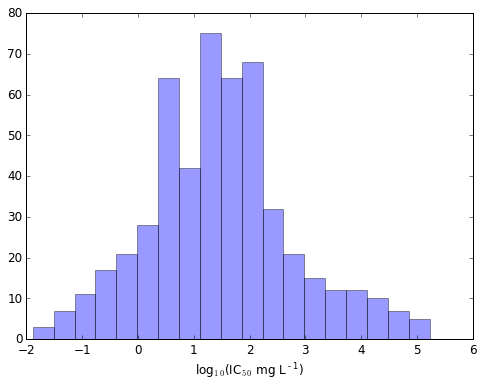

In [9]:
figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['savefig.dpi'] = 600  # 图片像素
sns.distplot(y,kde=False,norm_hist=False)
plt.xlabel('log'+'${_1}$'+'${_0}$'+'(IC'+'${_5}$'+'${_0}$'+' mg L'+'$\mathregular{^-}$'+'$\mathregular{^1}$)')
figure.savefig("./Result_fig_IC50_LightGBM/Log_IC50.jpg",bbox_inches='tight')

In [10]:
feature_plot_name = ['QD source', 'Core', 'Shell', 'QD diameter (nm)', 'Surface ligand',
       'Surface charge', 'Surface modification', 'Cell anatomical type',
       'Cell source species', 'Cell origin', 'Assay type', 'Delivery type',
       'Exposure time (hours)']
feature_plot_name

['QD source',
 'Core',
 'Shell',
 'QD diameter (nm)',
 'Surface ligand',
 'Surface charge',
 'Surface modification',
 'Cell anatomical type',
 'Cell source species',
 'Cell origin',
 'Assay type',
 'Delivery type',
 'Exposure time (hours)']

In [11]:
X_display = raw_data.loc[random_index,:].drop(['IC50-log-mgL-1'], axis=1)
y_display = data['IC50-log-mgL-1']
X_display.columns = feature_plot_name
X_display.head(5)

QD source  Core     Shell  QD diameter (nm)       Surface ligand  \
242    In-house  CdSe      ZnSe               4.0               Polyol   
315    In-house  CdTe  No-shell               3.3            Aminoacid   
101  Commercial  CdTe       CdS               5.0  Hydrophilic-Polymer   
277    In-house  CdTe      ZnTe               4.8           Alkylthiol   
467    In-house  CdSe       ZnS               5.0           Alkylthiol   

    Surface charge Surface modification Cell anatomical type  \
242     Zwitterion              Peptide          Endothelial   
315     Zwitterion              Peptide           Epithelial   
101       Negative           Unmodified           Epithelial   
277       Negative                Toxin           Fibroblast   
467       Negative           Unmodified             Myoblast   

    Cell source species Cell origin Assay type Delivery type  \
242              Human    Cell-line        MTT        Active   
315              Human    Cell-line        MTT        Active   
101              Human    Cell-line        MTT       Passive   
277               Mouse   Cell-line        MTT        Active   
467              Rabbit     Primary        MTT       Passive   

     Exposure time (hours)  
242                   24.0  
315                   12.0  
101                   12.0  
277                   24.0  
467                   24.0

# 2 LightGBM

## 2.1 GridSearchCV

In [12]:
parameter = {
    
   # 1.确定树的大小及复杂度
    # "max_depth": np.arange(5,15,1),
    # "num_leaves": np.arange(10,20,1),
    
   # 2.防止树过拟合
   # "min_child_samples": np.arange(1,10,1), 
    
   # 3.调整学习率
   #"learning_rate": np.arange(0,0.1,0.005),
}

model_gs = lgb.LGBMRegressor(n_estimators=1000,n_jobs=-1,max_depth=10,num_leaves=15,min_child_samples=7,learning_rate=0.045)
# ,max_depth=10,num_leaves=15,min_child_samples=7,learning_rate=0.045
grid_search = GridSearchCV(model_gs, param_grid = parameter, scoring='r2', cv=5, n_jobs=-1)
grid_search.fit(X, y, categorical_feature="auto")

print('best score: ', grid_search.best_score_)
print('best_params:', grid_search.best_params_)

LGBM_Gs_best = grid_search.best_estimator_

# print('RMSE:', abs(sum(cross_val_score(LGBM_Gs_best, X_sorted_summary_part, y, cv=5,scoring='neg_root_mean_squared_error'))/5))
print('RMSE:', abs(sum(cross_val_score(LGBM_Gs_best, X, y, cv=5,scoring='neg_root_mean_squared_error'))/5))

best score:  0.7440463476593926
best_params: {}
RMSE: 0.657073310324028


## 2.2 LightGBM modeling

RMSE_train: 0.19 
R2_train: 0.98 
RMSE_test: 0.68 
R2_test: 0.77 


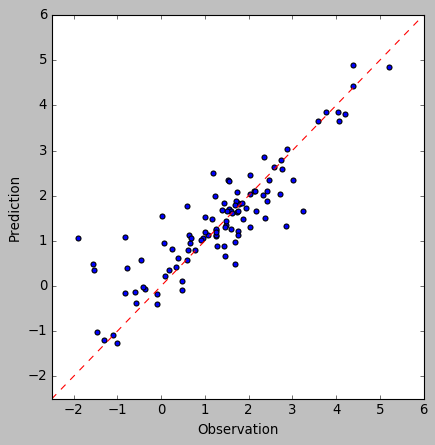

In [13]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32) #32

model = lgb.LGBMRegressor(n_estimators=1000,n_jobs=-1,max_depth=9, num_leaves=10, min_child_samples=3, min_child_weight=0,learning_rate=0.055)
model.fit(X_train, y_train, categorical_feature="auto")
y_pred = model.predict(X_test) 
y_train_pred = model.predict(X_train) 

print('RMSE_train: %.2f ' %sqrt(mean_squared_error(y_train, y_train_pred)))  # 训练集MSE
print('R2_train: %.2f ' %r2_score(y_train, y_train_pred))  # 训练集R方
print('RMSE_test: %.2f ' %sqrt(mean_squared_error(y_test, y_pred)))  # 测试集MSE
print('R2_test: %.2f ' %r2_score(y_test, y_pred))  # 测试集R方

figure = plt.figure(figsize=(6,6))  # 设定画布大小
plt.style.use('classic')
plt.xlim(-2.5, 6)
plt.ylim(-2.5, 6)
plt.plot([-2.5,6],[-2.5,6],color="r",linestyle='--')
plt.scatter(y_test, y_pred)
plt.xlabel('Observation')
plt.ylabel('Prediction')

plt.plot()
figure.savefig("./Result_fig_IC50_LightGBM/Predcitons_observations_label.jpg",dpi=600,bbox_inches='tight')

# 3 Interpretability

In [14]:
X_train_display = X_display.loc[X_train.index,:]
X_train_display

QD source    Core     Shell  QD diameter (nm)       Surface ligand  \
476    In-house    CdSe       ZnS          2.900000               Polyol   
204    In-house    CdTe  No-shell          2.600000           Alkylthiol   
1      In-house    CdSe  No-shell          3.370000           Alkylthiol   
214  Commercial  CdSeTe       ZnS          4.300000                  PEG   
407    In-house    CdSe       ZnS          6.000000         Aminopolymer   
..          ...     ...       ...               ...                  ...   
85     In-house    CdTe  No-shell          2.900000  Amphiphilic-polymer   
510    In-house    CdSe       ZnS          5.500000           Alkylthiol   
245    In-house    CdSe  No-shell          3.364486               Polyol   
273    In-house    CdTe      ZnTe          5.800000           Alkylthiol   
489    In-house    CdSe      ZnSe          4.500000               Polyol   

    Surface charge Surface modification Cell anatomical type  \
476        Neutral          Antioxidant           Epithelial   
204       Negative           Unmodified           Epithelial   
1          Neutral           Unmodified           Epithelial   
214       Positive           Unmodified  Monocyte-Macrophage   
407       Positive           Unmodified           Epithelial   
..             ...                  ...                  ...   
85         Neutral           Unmodified           Epithelial   
510       Negative           Unmodified           Epithelial   
245     Zwitterion              Peptide          Endothelial   
273       Negative           Unmodified           Fibroblast   
489     Zwitterion          Nucleicacid           Epithelial   

    Cell source species Cell origin   Assay type Delivery type  \
476              Human    Cell-line  Alamar-blue        Active   
204              Human    Cell-line          MTT       Passive   
1                Human      Primary          WST       Passive   
214               Mouse   Cell-line          MTT       Passive   
407              Human    Cell-line         CCK8       Passive   
..                  ...         ...          ...           ...   
85               Human    Cell-line         CCK8       Passive   
510              Human    Cell-line          MTS       Passive   
245              Human    Cell-line          MTT        Active   
273               Mouse   Cell-line          MTT       Passive   
489              Human    Cell-line          MTT        Active   

     Exposure time (hours)  
476                   24.0  
204                   10.0  
1                     22.0  
214                   48.0  
407                   24.0  
..                     ...  
85                    12.0  
510                   48.0  
245                   48.0  
273                   24.0  
489                   48.0  

[411 rows x 13 columns]

In [15]:
Model = model
select_X = X
display_dataset = X_display
select_y = y

## 3.1 Feature importance

### 3.1.1 LightGBM

In [16]:
fature_name = X_train.columns
fature_name

Index(['QD-source', 'Core', 'Shell', 'QD-diameter-nm', 'Surface-ligand',
       'Surface-charge', 'Surface-modification', 'Cell-anatomical-type',
       'Cell-source-species', 'Cell-origin', 'Assay-type', 'Delivery-type',
       'Exposure-time-hrs'],
      dtype='object')

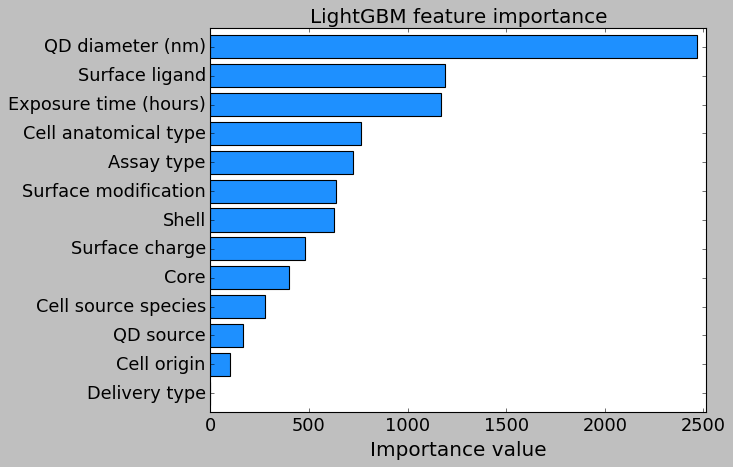

In [17]:
LightGBM_importance = Model.feature_importances_

figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['savefig.dpi'] = 300  # 图片像素
plt.rcParams['font.size'] ='16'
plt.margins(0.02)
sorted_idx = LightGBM_importance.argsort()
sorted_features = X_train.columns[sorted_idx]
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(feature_plot_name[int(itemindex)])

plt.barh(feature_this_plot,
         LightGBM_importance[sorted_idx], align='center', color="#1E90FF")

plt.title('LightGBM feature importance',fontsize=18)
plt.xlabel('Importance value',fontsize=18)

figure.savefig("./Result_fig_IC50_LightGBM/LightGBM_importance.jpg",bbox_inches='tight')

### 3.1.2 Permutation

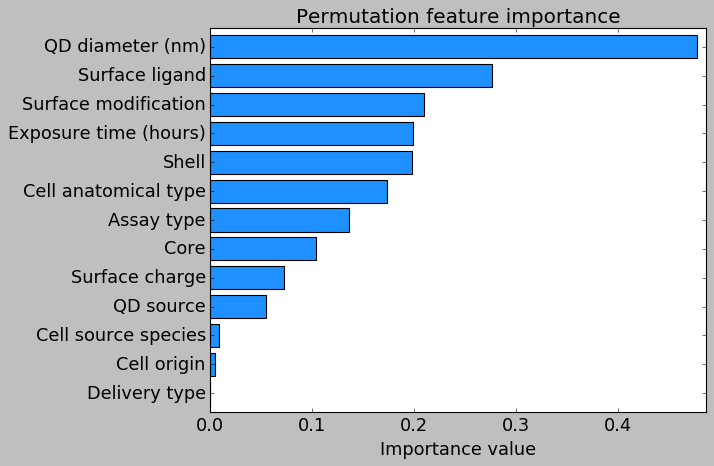

In [18]:
result = permutation_importance(Model, X_train, y_train, scoring='r2', n_repeats=10, random_state=0, n_jobs=-1)
Permutation_importance = result.importances_mean

figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['savefig.dpi'] = 300  # 图片像素
plt.rcParams['font.size'] ='16'
plt.margins(0.02)
sorted_idx = Permutation_importance.argsort()
sorted_features = X_train.columns[sorted_idx]
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(feature_plot_name[int(itemindex)])

plt.barh(feature_this_plot,
         Permutation_importance[sorted_idx], align='center', color="#1E90FF")

plt.title('Permutation feature importance',fontsize=18)
plt.xlabel('Importance value',fontsize=16)

figure.savefig("./Result_fig_IC50_LightGBM/Permutation_importance.jpg",bbox_inches='tight')

### 3.1.3 SHAP

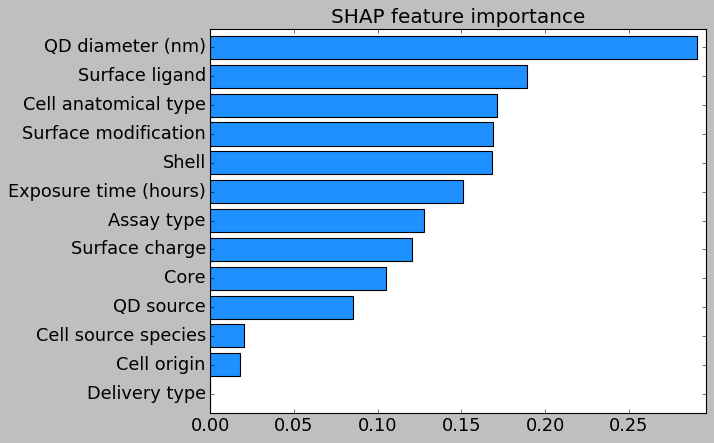

In [19]:
explainer = shap.TreeExplainer(model=Model, data=None, model_output='raw', feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_train)
global_shap_values = np.abs(shap_values).mean(0)

figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
plt.rcParams['savefig.dpi'] = 300  # 图片像素
plt.rcParams['font.size'] ='16'
plt.margins(0.02)
sorted_idx = global_shap_values.argsort()
sorted_features = X_train.columns[sorted_idx]
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(feature_plot_name[int(itemindex)])

plt.barh(feature_this_plot,
         global_shap_values[sorted_idx], align='center', color="#1E90FF")

plt.title('SHAP feature importance',fontsize=18)

figure.savefig("./Result_fig_IC50_LightGBM/Shap_importance.jpg",bbox_inches='tight')

In [20]:
global_shap_values[sorted_idx][::-1]

array([0.2904206 , 0.18904425, 0.17129966, 0.16868466, 0.16843738,
       0.15061727, 0.12736827, 0.12048713, 0.1047564 , 0.08500994,
       0.02031991, 0.01768567, 0.        ])

### 3.1.4 Importance summary

In [21]:
# 计算相对重要性，最大为1
LightGBM_importance_relative = LightGBM_importance/max(LightGBM_importance)
Permutation_importance_relative = Permutation_importance/max(Permutation_importance)
shap_values__relative = global_shap_values/max(global_shap_values)

# 以 relative importance 之和为基准进行排序
importance_sum = LightGBM_importance_relative+Permutation_importance_relative+shap_values__relative
sorted_idx_sum = importance_sum.argsort()
sorted_features = X_train.columns[sorted_idx_sum][::-1]

np.save('sorted_features.npy',sorted_features.tolist())

importance_df = pd.DataFrame({'Feature':X_train.columns[sorted_idx_sum],
                    'LightGBM':LightGBM_importance_relative[sorted_idx_sum],
                   'Permutatio':Permutation_importance_relative[sorted_idx_sum],
                   'SHAP':shap_values__relative[sorted_idx_sum]},
                    )

In [22]:
sorted_features

Index(['QD-diameter-nm', 'Surface-ligand', 'Exposure-time-hrs',
       'Surface-modification', 'Cell-anatomical-type', 'Shell', 'Assay-type',
       'Surface-charge', 'Core', 'QD-source', 'Cell-source-species',
       'Cell-origin', 'Delivery-type'],
      dtype='object')

In [23]:
importance_df = pd.DataFrame(columns=('Feature','Method','Relative importance value'))
n_feature = len(X_train.columns)

for i in range(0,n_feature):
    importance_df.loc[i,'Feature'] = X_train.columns[sorted_idx_sum][-i-1]
    importance_df.loc[i,'Method'] = 'LightGBM'
    importance_df.loc[i,'Relative importance value'] = LightGBM_importance_relative[sorted_idx_sum][-i-1]
    
for i in range(0,n_feature):
    importance_df.loc[i+n_feature,'Feature'] = X_train.columns[sorted_idx_sum][-i-1]
    importance_df.loc[i+n_feature,'Method'] = 'Permutation'
    importance_df.loc[i+n_feature,'Relative importance value'] = Permutation_importance_relative[sorted_idx_sum][-i-1]
    
for i in range(0,n_feature):
    importance_df.loc[i+n_feature*2,'Feature'] = X_train.columns[sorted_idx_sum][-i-1]
    importance_df.loc[i+n_feature*2,'Method'] = 'SHAP'
    importance_df.loc[i+n_feature*2,'Relative importance value'] = shap_values__relative[sorted_idx_sum][-i-1]
    
LightGBM_sorted_value = sorted(importance_df.loc[:,'Relative importance value'][0:n_feature].values,reverse=True)
Permutation_sorted_value = sorted(importance_df.loc[:,'Relative importance value'][n_feature:n_feature*2].values,reverse=True)
SHAP_sorted_value = sorted(importance_df.loc[:,'Relative importance value'][n_feature*2:n_feature*3].values,reverse=True)

annotate_LightGBM = []
annotate_Permutation = []
annotate_SHAP = []

for i in range(0,n_feature,1):
    annotate_LightGBM.append(LightGBM_sorted_value.index(importance_df.loc[:,'Relative importance value'][0:n_feature].values[i])+1)
    annotate_Permutation.append(Permutation_sorted_value.index(importance_df.loc[:,'Relative importance value'][n_feature:n_feature*2].values[i])+1)
    annotate_SHAP.append(SHAP_sorted_value.index(importance_df.loc[:,'Relative importance value'][n_feature*2:n_feature*3].values[i])+1)
    
annotate_value = np.hstack((annotate_LightGBM, annotate_Permutation,annotate_SHAP))
annotate_value

array([ 1,  2,  3,  6,  4,  7,  5,  8,  9, 11, 10, 12, 13,  1,  2,  4,  3,
        6,  5,  7,  9,  8, 10, 11, 12, 13,  1,  2,  6,  4,  3,  5,  7,  8,
        9, 10, 11, 12, 13])

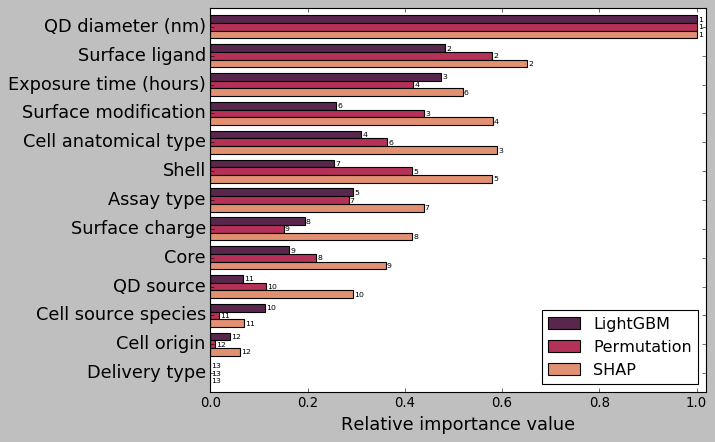

In [24]:
feature_this_plot = []
for item in sorted_features:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(feature_plot_name[int(itemindex)])

figure = plt.figure(figsize=(8,6))
plt.style.use('classic')
bar = sns.barplot(data = importance_df,y='Feature',x='Relative importance value',hue='Method',palette="rocket")
bar.set_ylabel('',fontsize=16)
bar.set_xlabel('Relative importance value',fontsize=16)
bar.set_yticklabels(feature_this_plot,fontsize=16)
plt.legend(loc='lower right')
i=0
plt.margins(0.02)
for p in bar.patches:
    bar.annotate("%d" %annotate_value[i], xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(1, -0.5), textcoords='offset points', ha="left", va="center",fontsize=7)
    i=i+1
figure.savefig("./Result_fig_IC50_LightGBM/Importance_summary.jpg",dpi=300,bbox_inches='tight')

In [25]:
select_X.columns

Index(['QD-source', 'Core', 'Shell', 'QD-diameter-nm', 'Surface-ligand',
       'Surface-charge', 'Surface-modification', 'Cell-anatomical-type',
       'Cell-source-species', 'Cell-origin', 'Assay-type', 'Delivery-type',
       'Exposure-time-hrs'],
      dtype='object')

In [26]:
sorted_idx_sum = LightGBM_importance.argsort()
sorted_features = select_X.columns[sorted_idx_sum][::-1]
X_sorted_summary= X.loc[:,sorted_features]
X_sorted_summary

QD-diameter-nm  Surface-ligand  Exposure-time-hrs  Cell-anatomical-type  \
242             4.0              11               24.0                     0   
315             3.3               2               12.0                     1   
101             5.0               6               12.0                     1   
277             4.8               0               24.0                     2   
467             5.0               0               24.0                    12   
..              ...             ...                ...                   ...   
10              9.0               5               24.0                     2   
253             6.2               5               20.0                     9   
439             3.2              11               48.0                     1   
465             3.1               8               24.0                     1   
212             4.3               9               48.0                    10   

     Assay-type  Surface-modification  Shell  Surface-charge  Core  \
242           9                     6      6               3     2   
315           9                     6      4               3     4   
101           9                    10      0               0     4   
277           9                     9      8               0     4   
467           9                    10      5               0     2   
..          ...                   ...    ...             ...   ...   
10            9                    10      5               0     2   
253          11                     0      4               2     4   
439           9                     3      4               3     2   
465           9                     8      4               1     1   
212           9                    10      5               1     3   

     Cell-source-species  QD-source  Cell-origin  Delivery-type  
242                    4          1            0              0  
315                    4          1            0              0  
101                    4          0            0              1  
277                    6          1            0              0  
467                   11          1            1              1  
..                   ...        ...          ...            ...  
10                     0          0            1              1  
253                    4          0            0              0  
439                    4          1            0              0  
465                    4          1            0              0  
212                    6          0            0              1  

[514 rows x 13 columns]

n_feature = len(sorted_features)
R2_summary = []
RMSE_summary = []

for i in range(1,n_feature+1,1):
    parameter = {
    
       # 1.确定树的大小及复杂度
         "max_depth": np.arange(2,i+7,1),
         "num_leaves": np.arange(2,i+18,1),
    
       # 2.防止树过拟合
       # "min_child_samples": np.arange(1,35,5), 
    
       # 3.调整学习率
       # "learning_rate": np.arange(0,0.4,0.005),
    }

    X_sorted_summary_part = X_sorted_summary.iloc[:,0:i]

    model_gs = lgb.LGBMRegressor(n_estimators=1000,n_jobs=-1,)
    grid_search = GridSearchCV(model_gs, param_grid = parameter, scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_sorted_summary_part, y, categorical_feature="auto")

    # print('best score (r2): ', grid_search.best_score_)
    # print('best_params:', grid_search.best_params_)

    LGBM_Gs_best = grid_search.best_estimator_

    # print('RMSE:', abs(sum(cross_val_score(LGBM_Gs_best, X_sorted_summary_part, y, cv=5,scoring='neg_root_mean_squared_error'))/5))
    
    R2_summary.append(grid_search.best_score_)
    RMSE_summary.append(abs(sum(cross_val_score(LGBM_Gs_best, X_sorted_summary_part, y, cv=5,scoring='neg_root_mean_squared_error'))/5))

In [27]:
R2_summary= [0.11248833267124655, 0.36277652513204367, 0.3754143306862989, 0.45572549682186236, 0.547971583576605, 0.6341465937294727, 0.7180148497078779, 0.7118764103105875, 0.7127438788162983, 0.7078037897015257, 0.7167879591550926, 0.718679544758604, 0.718679544758604]

RMSE_summary = [1.2235293437211054, 1.0355400705284534, 1.0253980457328917, 0.9572124836567355, 0.8716103824811732, 0.7827893452687741, 0.6873145907349129, 0.6936008645268207, 0.6934839774165702, 0.7011905101438662, 0.6905766593586807, 0.6882217831289487, 0.6882217831289487]

RMSE_summary
[1.2235293437211054, 1.0355400705284534, 1.0253980457328917, 0.8992757410371205, 0.8370100662592203, 0.7378640947614279, 0.6873145907349129, 0.6936008645268207, 0.6934839774165702, 0.6733355298761143, 0.6905766593586807, 0.6882228703112895, 0.6882228703112895]

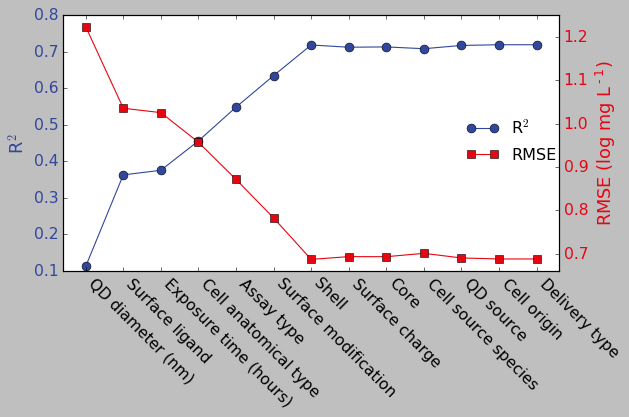

In [28]:
fig, ax1 = plt.subplots(figsize=(8,4)) 
plt.style.use('classic')

plot_feature = sorted_features
feature_this_plot = []
for item in plot_feature:
    itemindex = np.argwhere(fature_name == item)
    feature_this_plot.append(feature_plot_name[int(itemindex)])
    
plt.plot(range(1,len(R2_summary)+1),R2_summary,"-o",MarkerSize=8,color='#31479C')
plt.xticks(range(1,len(R2_summary)+1), feature_this_plot, rotation=-45,ha ='left',fontsize=14)
plt.yticks(color='#31479C',fontsize=14)
plt.ylabel('R'+'${^2}$',color='#31479C',fontsize=16)
plt.legend(['R'+'${^2}$'],frameon=False,loc=(0.8,0.5))
#plt.margins(0.05)

ax2 = ax1.twinx() 

    
plt.plot(range(1,len(RMSE_summary)+1),RMSE_summary,"-s",MarkerSize=8,color='#E60612')
plt.ylabel('RMSE (log mg L'+'$\mathregular{^-}$'+'$\mathregular{^1}$)',color='#E60612',fontsize=16)
plt.yticks(color='#E60612',fontsize=14)
plt.legend(["RMSE"],frameon=False,loc=(0.8,0.4))

plt.margins(0.05)

plt.show() 
fig.savefig("./Result_fig_IC50_LightGBM/LightGBM_feature_summary_two.jpg",dpi=300,bbox_inches='tight')

## 3.2 SHAP local feature contributions

In [29]:
feature_plot_name = ['QD source', 'Core', 'Shell', 'QD diameter (nm)', 'Surface ligand',
       'Surface charge', 'Surface modification', 'Cell anatomical type',
       'Cell source species', 'Cell origin', 'Assay type', 'Delivery type',
       'Exposure time (hours)']
feature_plot_name

['QD source',
 'Core',
 'Shell',
 'QD diameter (nm)',
 'Surface ligand',
 'Surface charge',
 'Surface modification',
 'Cell anatomical type',
 'Cell source species',
 'Cell origin',
 'Assay type',
 'Delivery type',
 'Exposure time (hours)']

In [30]:
select_X.columns = feature_plot_name
select_X

QD source  Core  Shell  QD diameter (nm)  Surface ligand  Surface charge  \
242          1     2      6               4.0              11               3   
315          1     4      4               3.3               2               3   
101          0     4      0               5.0               6               0   
277          1     4      8               4.8               0               0   
467          1     2      5               5.0               0               0   
..         ...   ...    ...               ...             ...             ...   
10           0     2      5               9.0               5               0   
253          0     4      4               6.2               5               2   
439          1     2      4               3.2              11               3   
465          1     1      4               3.1               8               1   
212          0     3      5               4.3               9               1   

     Surface modification  Cell anatomical type  Cell source species  \
242                     6                     0                    4   
315                     6                     1                    4   
101                    10                     1                    4   
277                     9                     2                    6   
467                    10                    12                   11   
..                    ...                   ...                  ...   
10                     10                     2                    0   
253                     0                     9                    4   
439                     3                     1                    4   
465                     8                     1                    4   
212                    10                    10                    6   

     Cell origin  Assay type  Delivery type  Exposure time (hours)  
242            0           9              0                   24.0  
315            0           9              0                   12.0  
101            0           9              1                   12.0  
277            0           9              0                   24.0  
467            1           9              1                   24.0  
..           ...         ...            ...                    ...  
10             1           9              1                   24.0  
253            0          11              0                   20.0  
439            0           9              0                   48.0  
465            0           9              0                   24.0  
212            0           9              1                   48.0  

[514 rows x 13 columns]

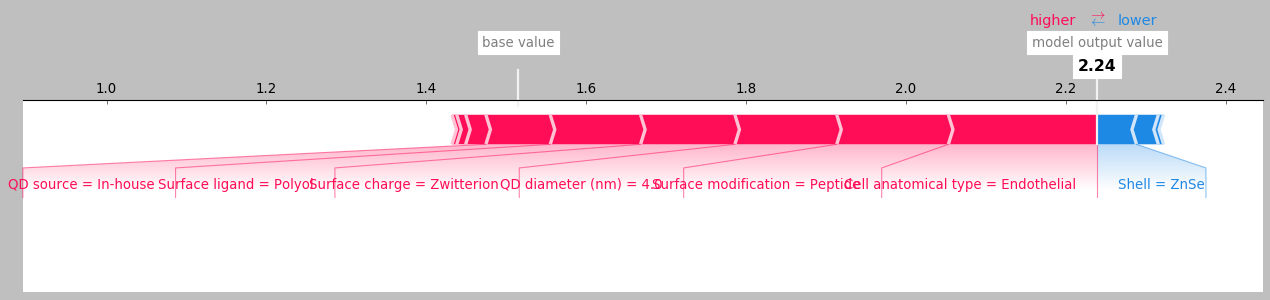

In [31]:
shap_values = explainer.shap_values(select_X)
ax=shap.force_plot(explainer.expected_value,
                shap_values[0, :],
                display_dataset.iloc[0,:], show=False, matplotlib=True)

ax.savefig("./Result_fig_IC50_LightGBM/Local_Shap_sample.jpg",dpi=300,bbox_inches='tight')

In [32]:
shap.initjs()
# 可视化第一个样本预测的解释
# 所有样本Shap图
shap.force_plot(explainer.expected_value, shap_values, display_dataset)

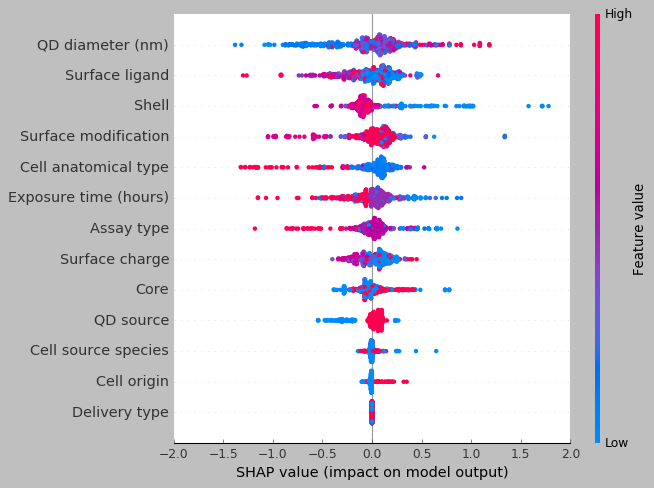

In [33]:
figure = plt.figure()
plt.rcParams['savefig.dpi'] = 300  # 图片像素
shap.summary_plot(shap_values, features=select_X, max_display=20)
figure.savefig("./Result_fig_IC50_LightGBM/Local_Shap_summary_feature.jpg",bbox_inches='tight')

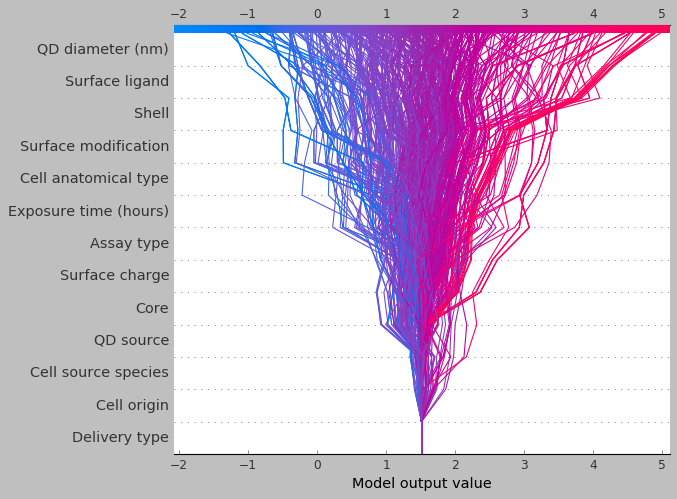

In [34]:
figure = plt.figure()
plt.rcParams['savefig.dpi'] = 300  # 图片像素
shap.decision_plot(explainer.expected_value,
                   shap_values, select_X.columns)
figure.savefig("./Result_fig_IC50_LightGBM/Local_Shap_summary_decesion.jpg",bbox_inches='tight')

## 3.3 SHAP feature interactions

In [35]:
Category_feature = ['QD source','Core','Shell','Surface ligand','Surface charge','Surface modification',
                    'Cell anatomical type','Cell source species','Cell origin','Assay type','Delivery type']
np.array(shap_values).shape

(514, 13)

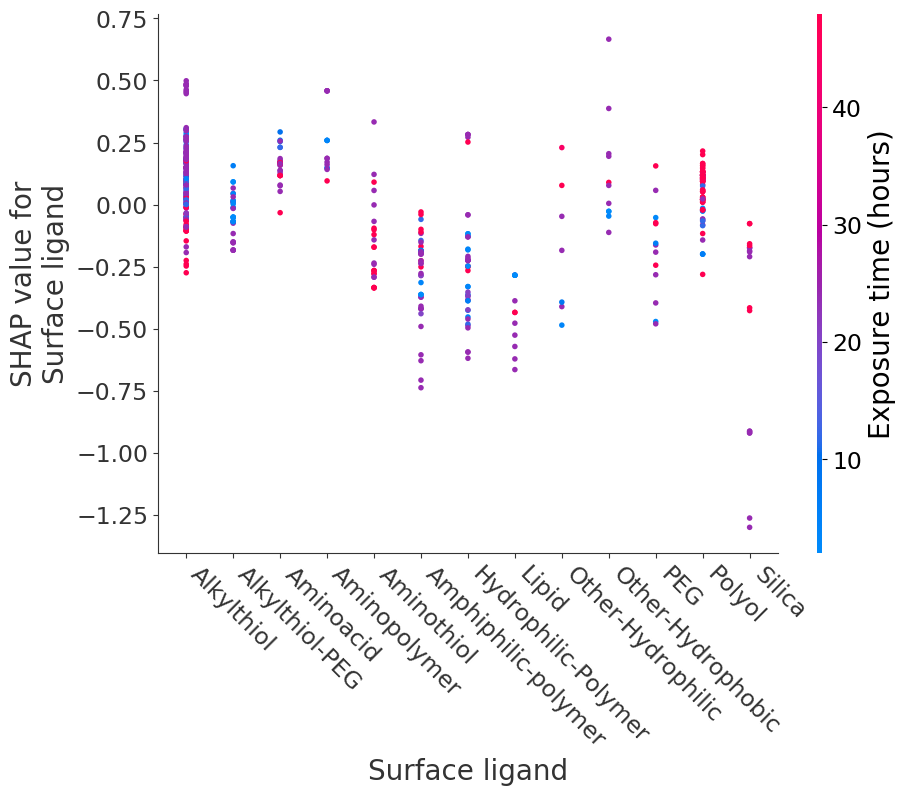

In [36]:
feature1 = 'Surface ligand'
feature2 = 'Exposure time (hours)'

plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 7))

ax_shap = shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,
                               display_features=display_dataset,interaction_index=feature2,)

plt.rcParams.update({'font.size': 5})

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')


fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

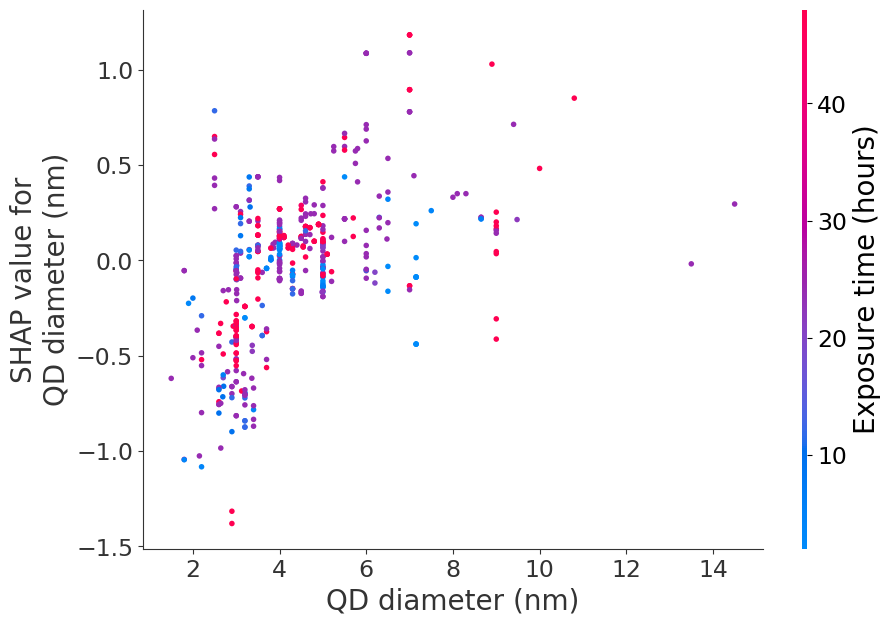

In [37]:
feature1 = 'QD diameter (nm)'
feature2 = 'Exposure time (hours)'
fig, ax = plt.subplots(figsize=(10, 7))

shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

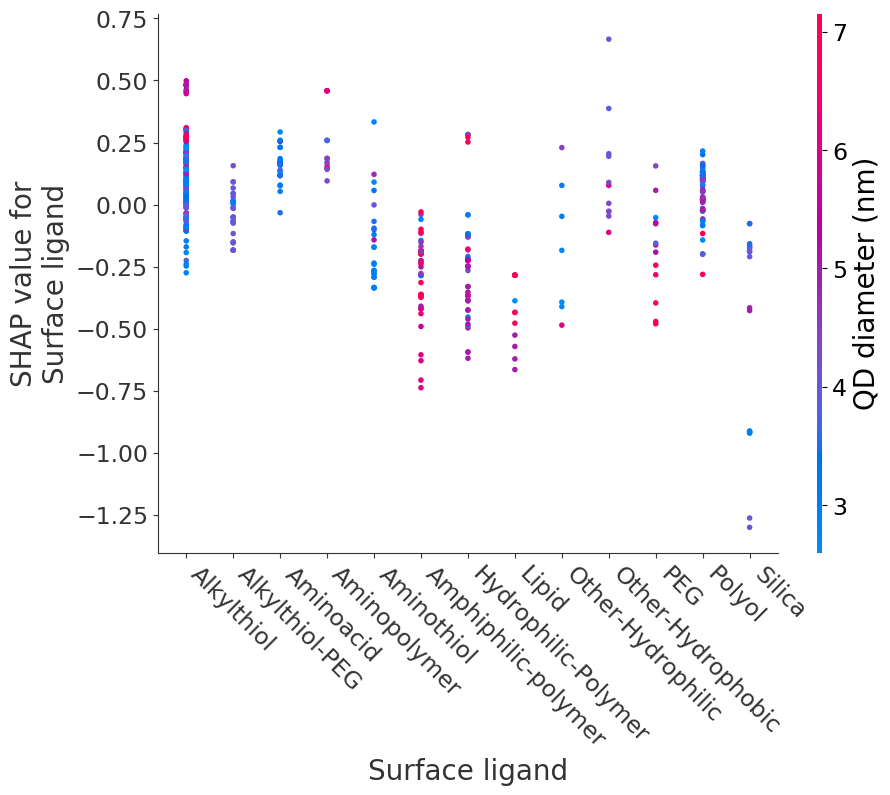

In [38]:
feature1 = 'Surface ligand'
feature2 = 'QD diameter (nm)'
fig, ax = plt.subplots(figsize=(10, 7))

shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

plt.style.use('default')
for feature in select_X.columns:
    fig, ax = plt.subplots(figsize=(10, 7))
    shap.dependence_plot(feature, shap_values, select_X,ax=ax,show=False,display_features=display_dataset)
    
    if feature in Category_feature:
        category_num = max(select_X.loc[:,feature])+1
        xtickslabel = []
        for i in range(category_num):
            xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature])
        ax.set_xticks(range(0,category_num))
        ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
    fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s.jpg"%(feature),dpi=300,bbox_inches='tight')

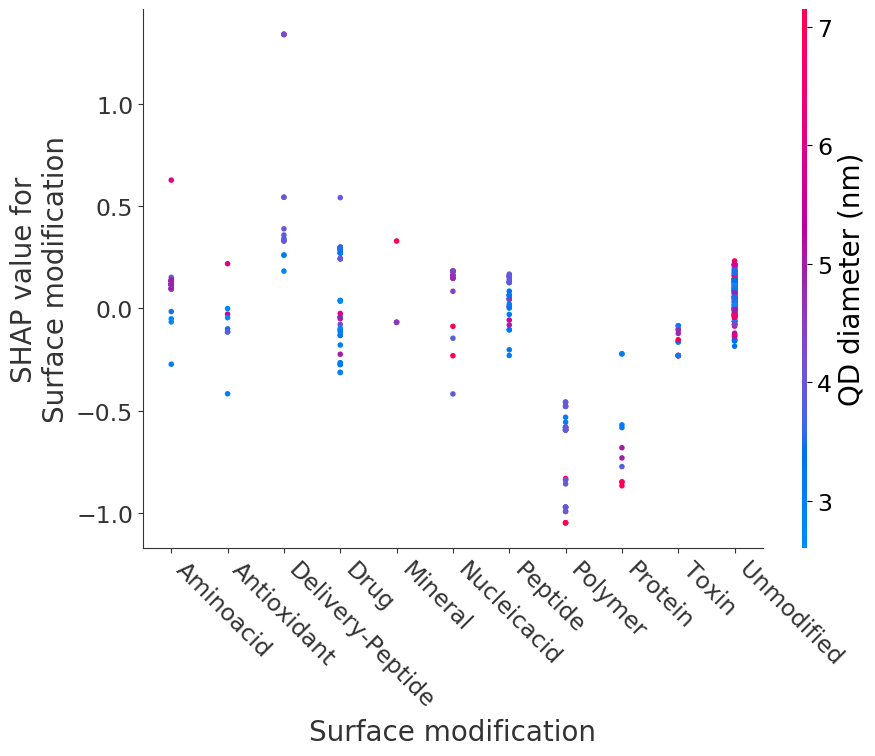

In [39]:
feature1 = 'Surface modification'
feature2 = 'QD diameter (nm)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

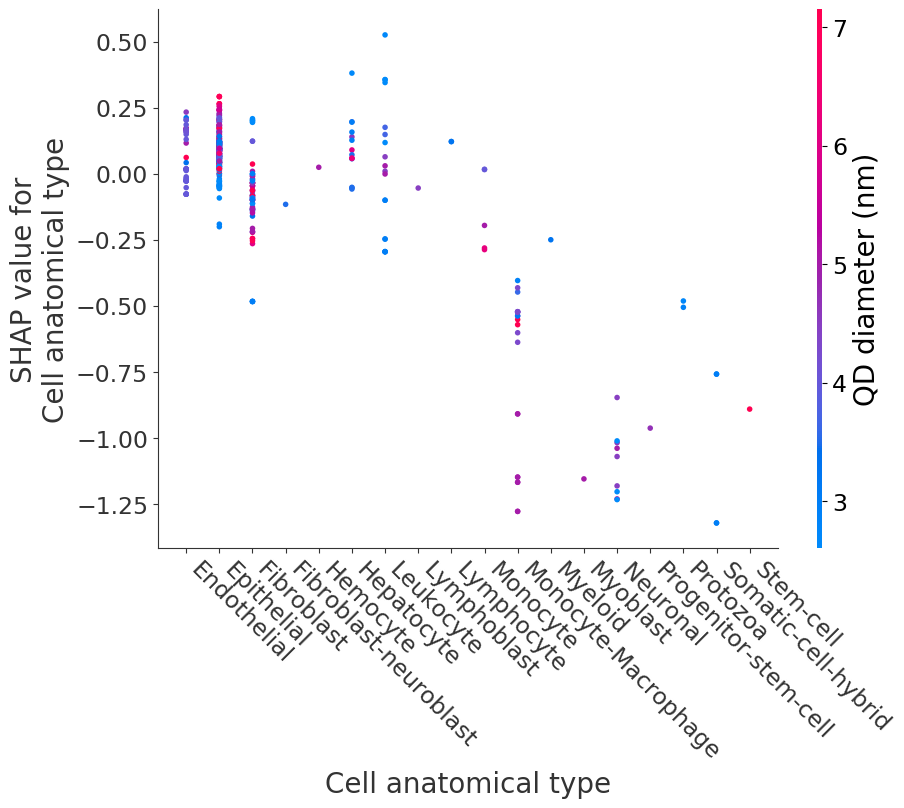

In [40]:
feature1 = 'Cell anatomical type'
feature2 = 'QD diameter (nm)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

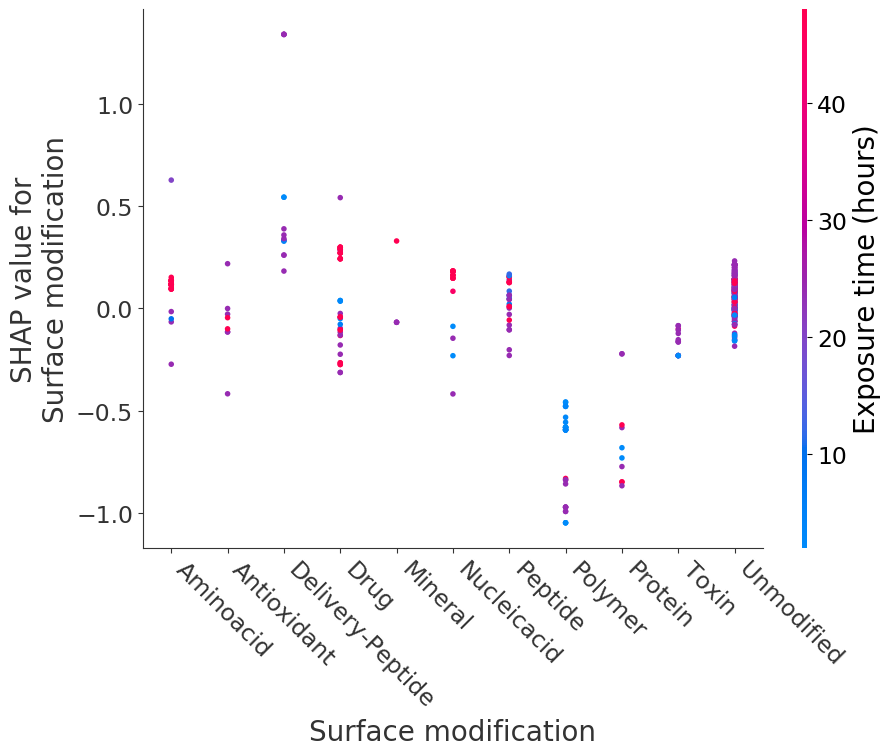

In [41]:
feature1 = 'Surface modification'
feature2 = 'Exposure time (hours)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

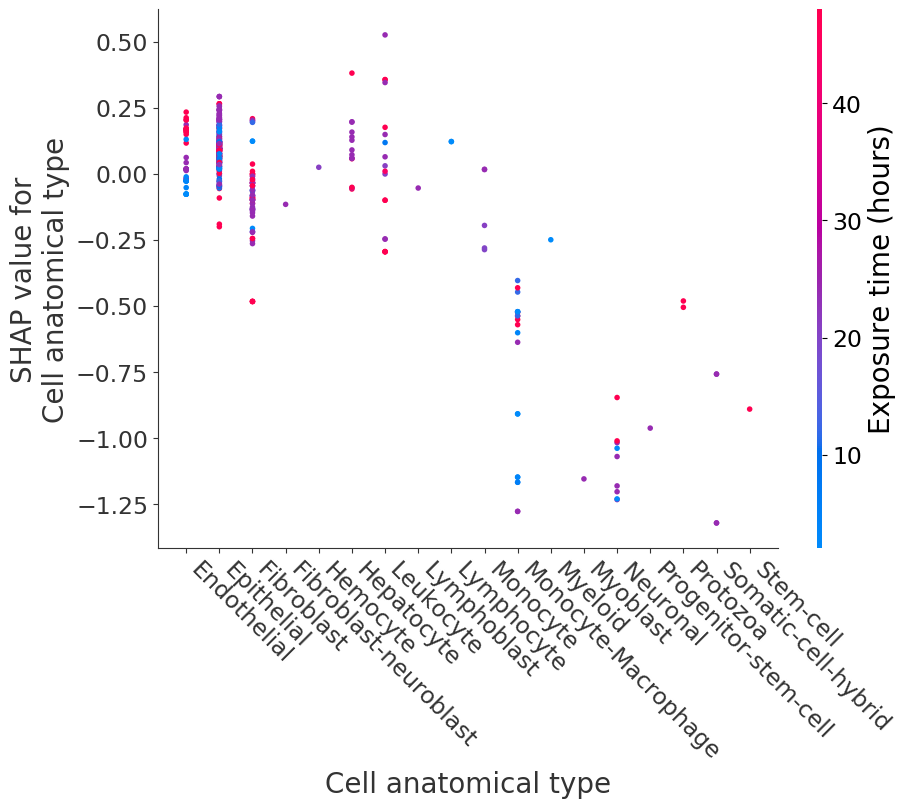

In [42]:
feature1 = 'Cell anatomical type'
feature2 = 'Exposure time (hours)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)


if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

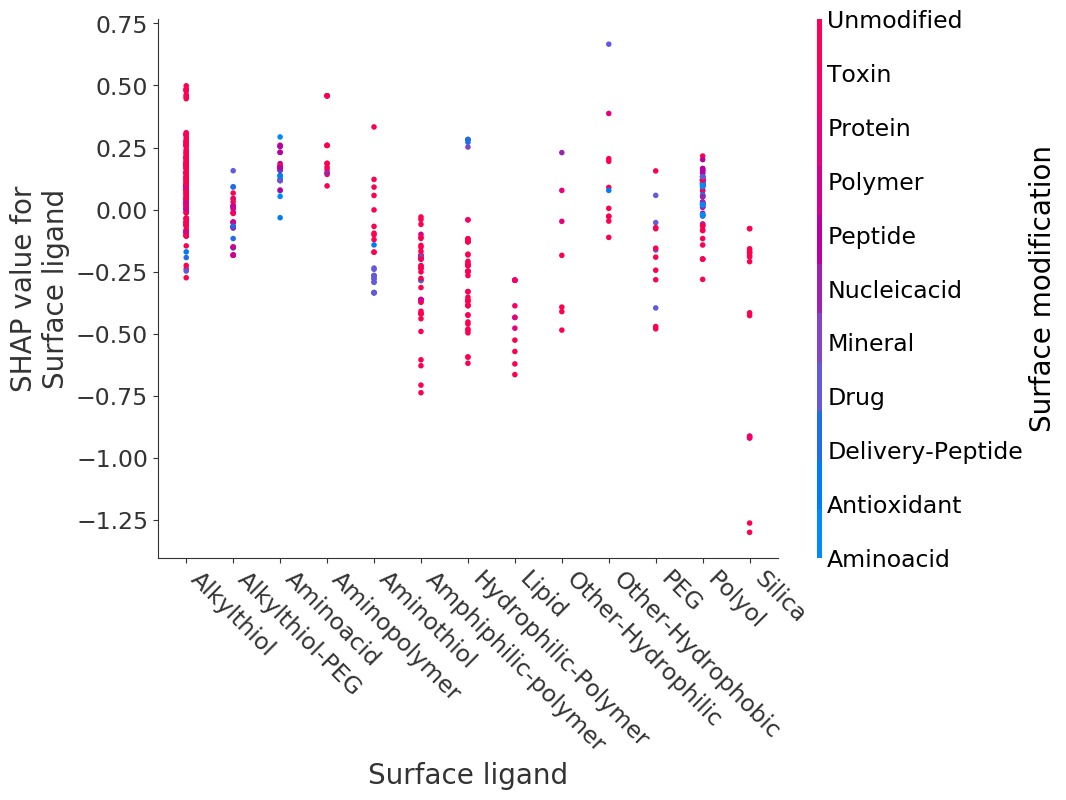

In [43]:
feature1 = 'Surface ligand'
feature2 = 'Surface modification'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

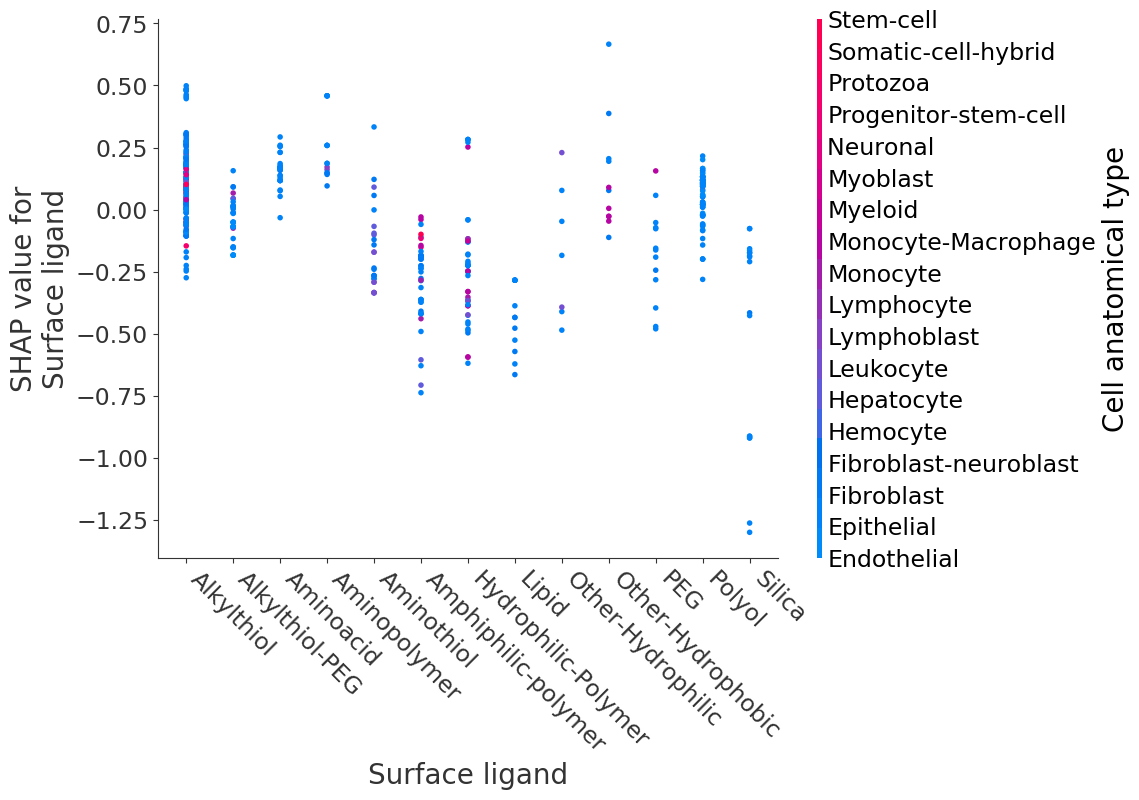

In [44]:
feature1 = 'Surface ligand'
feature2 = 'Cell anatomical type'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

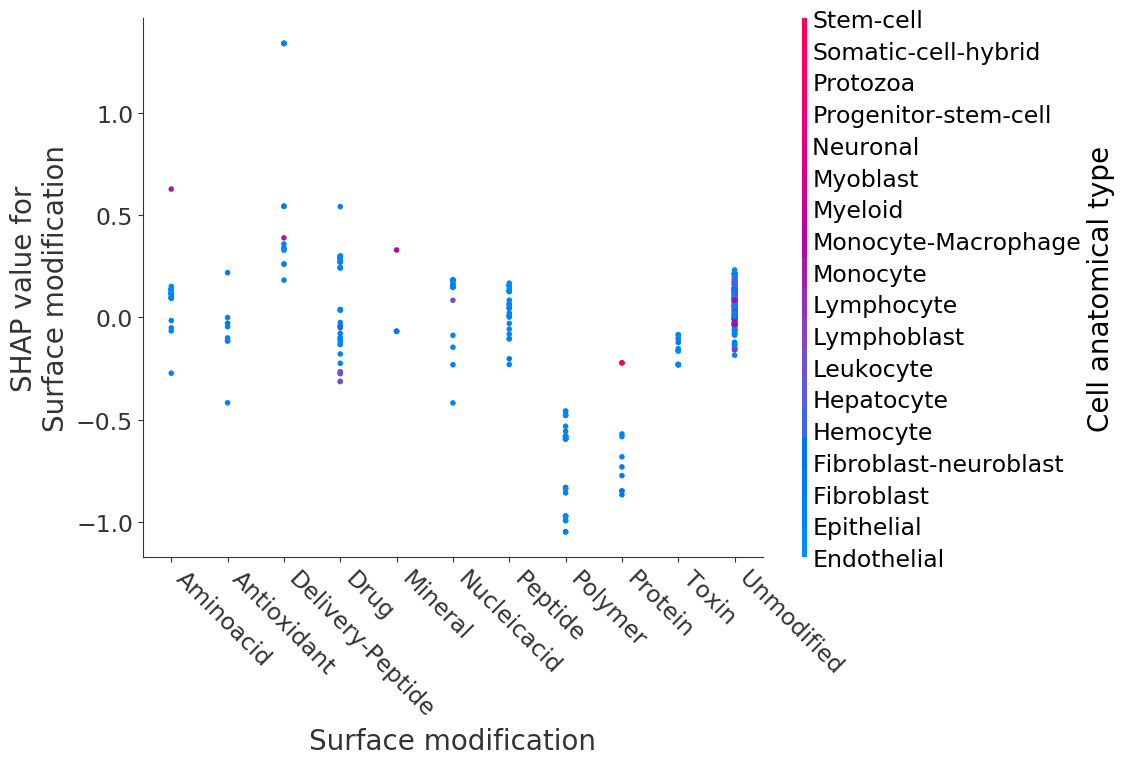

In [45]:
feature1 = 'Surface modification'
feature2 = 'Cell anatomical type'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot(feature1, shap_values, select_X,ax=ax, show=False,display_features=display_dataset,interaction_index=feature2,)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')

fig.savefig("./Result_fig_IC50_LightGBM/SHAP_dependence_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

In [46]:
np.array(shap_values).shape

(514, 13)

In [47]:
shap_interaction_values = shap.TreeExplainer(model=Model).shap_interaction_values(select_X)

In [48]:
select_X.columns

Index(['QD source', 'Core', 'Shell', 'QD diameter (nm)', 'Surface ligand',
       'Surface charge', 'Surface modification', 'Cell anatomical type',
       'Cell source species', 'Cell origin', 'Assay type', 'Delivery type',
       'Exposure time (hours)'],
      dtype='object')

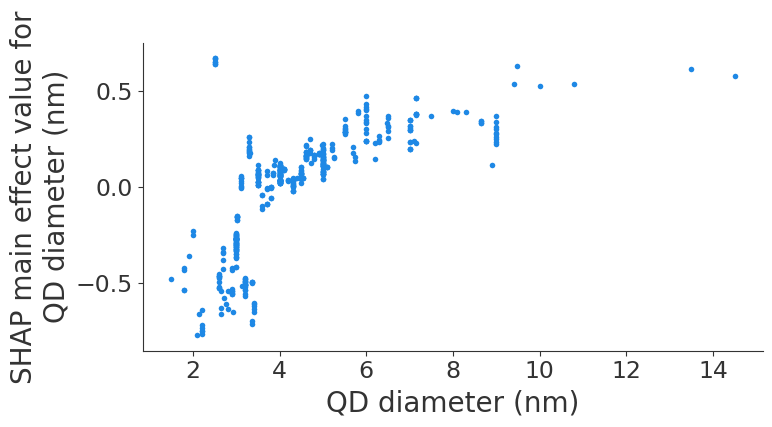

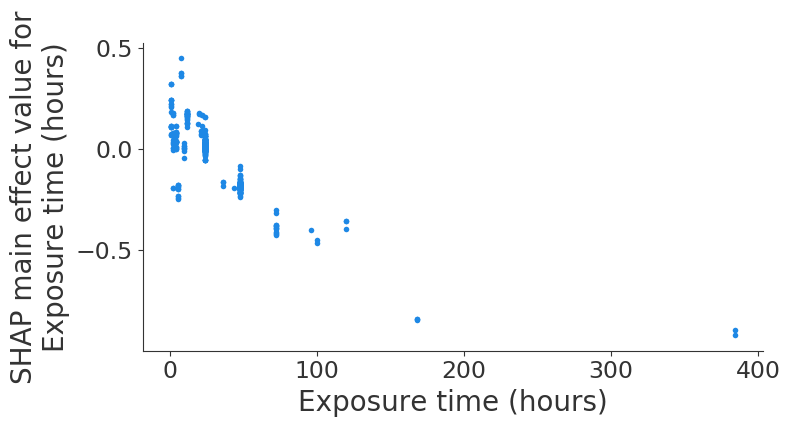

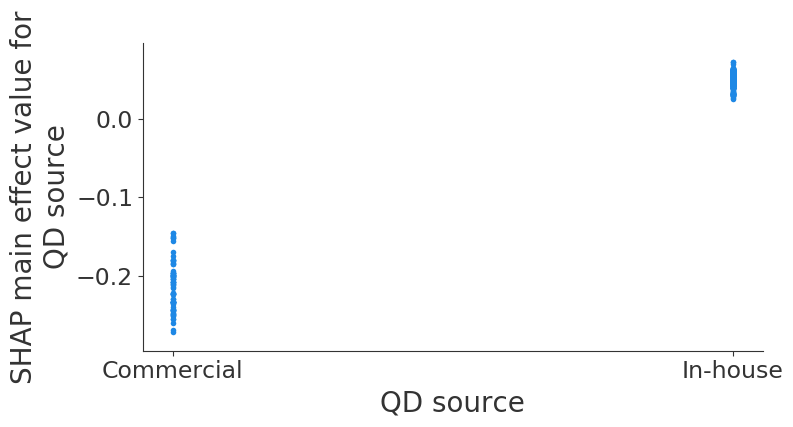

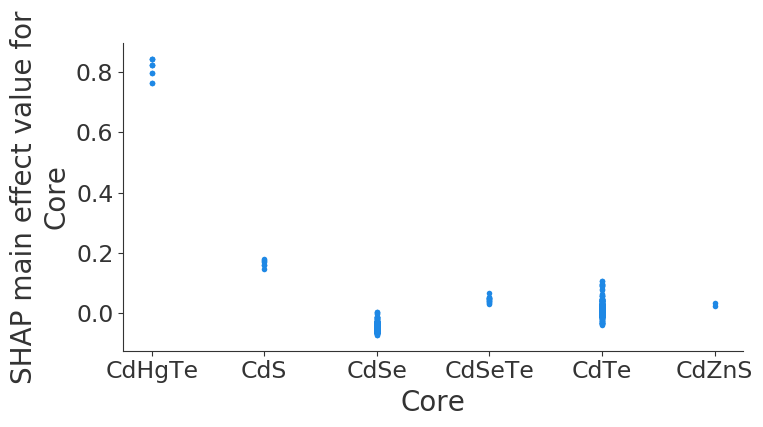

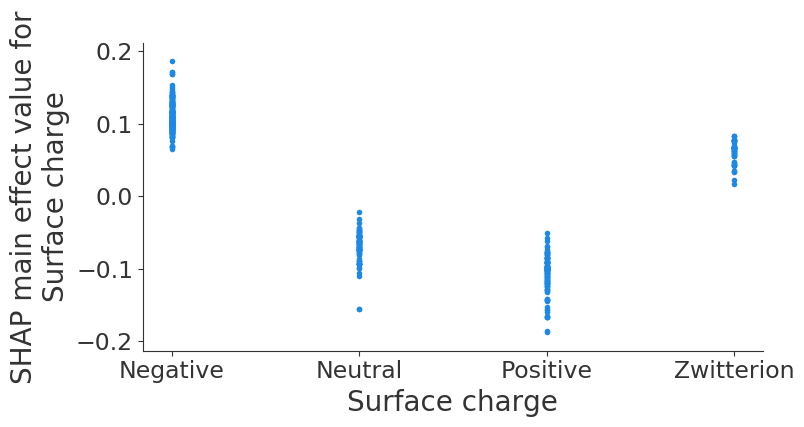

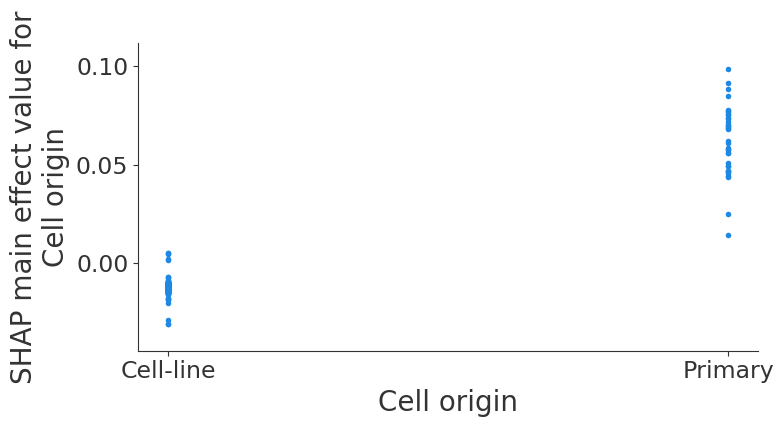

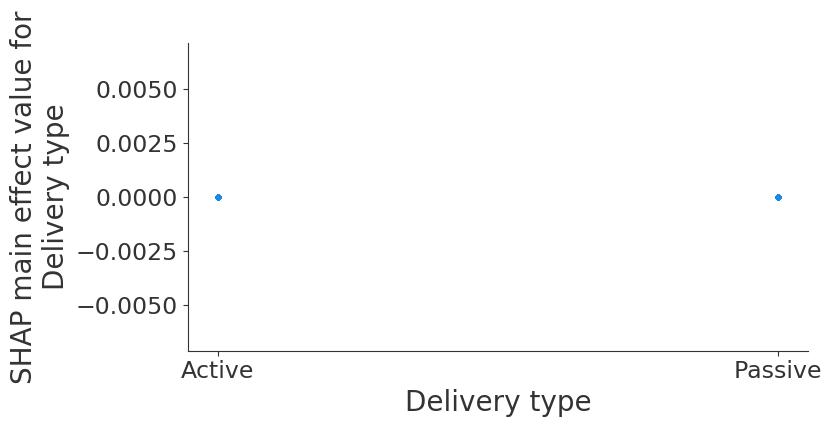

In [49]:
for feature in ['QD diameter (nm)','Exposure time (hours)','QD source','Core', 'Surface charge','Cell origin','Delivery type']:
    
    fig, ax = plt.subplots(figsize=(8, 4))
    shap.dependence_plot((feature, feature), shap_interaction_values, select_X, show=False,display_features=display_dataset, ax=ax)
    
    if feature in Category_feature:
        category_num = max(select_X.loc[:,feature])+1
        xtickslabel = []
        for i in range(category_num):
            xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature]==i)][0],feature])
        ax.set_xticks(range(0,category_num))
        ax.set_xticklabels(xtickslabel,rotation=0)    

    fig.savefig("./Result_fig_IC50_LightGBM/Main_effects_%s.jpg"%(feature),dpi=300,bbox_inches='tight')   

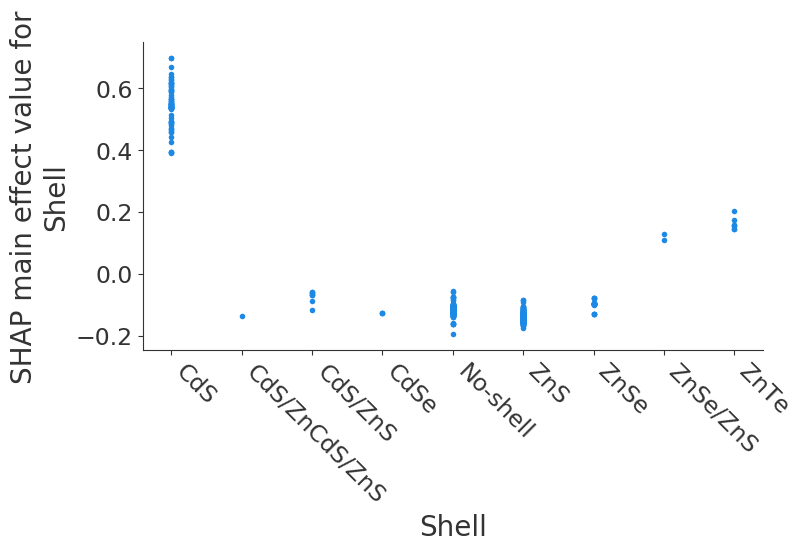

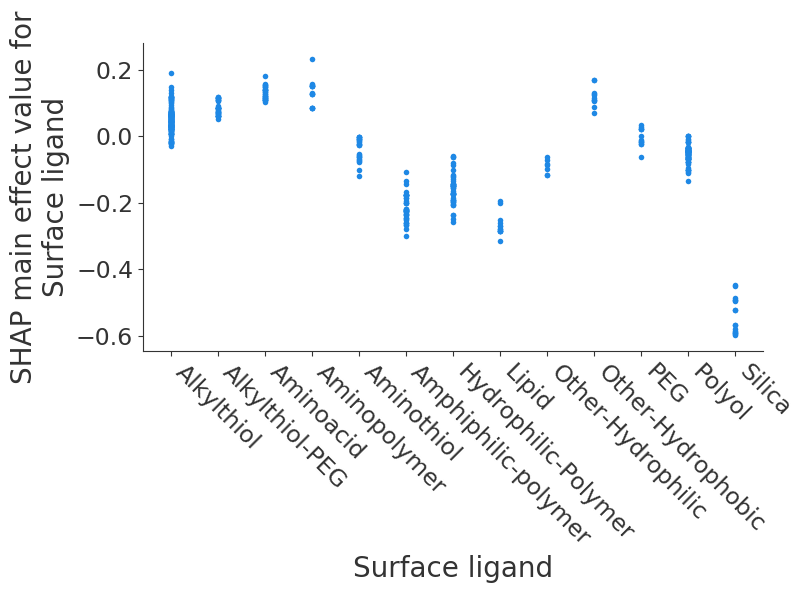

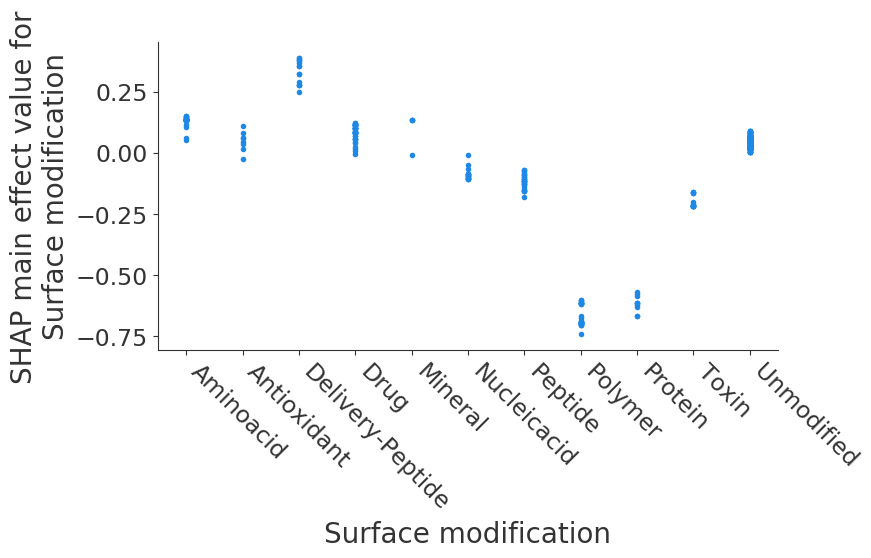

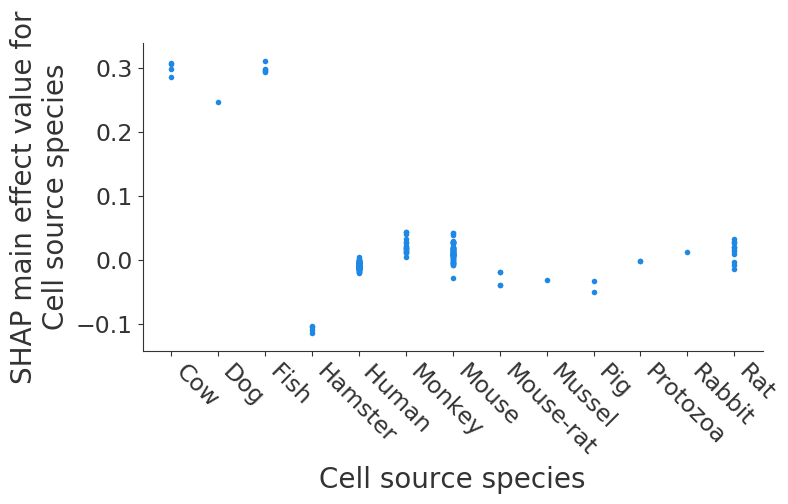

In [50]:
plt.style.use('default')
for feature in ['Shell','Surface ligand','Surface modification','Cell source species']:
    
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4, forward=True)
    shap.dependence_plot((feature, feature), shap_interaction_values, select_X, show=False,display_features=display_dataset, ax=ax)

    if feature in Category_feature:
        category_num = max(select_X.loc[:,feature])+1
        xtickslabel = []
        for i in range(category_num):
            xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature]==i)][0],feature])
        ax.set_xticks(range(0,category_num))
        ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')    
        
    fig.savefig("./Result_fig_IC50_LightGBM/Main_effects_%s.jpg"%(feature),dpi=300,bbox_inches='tight')   

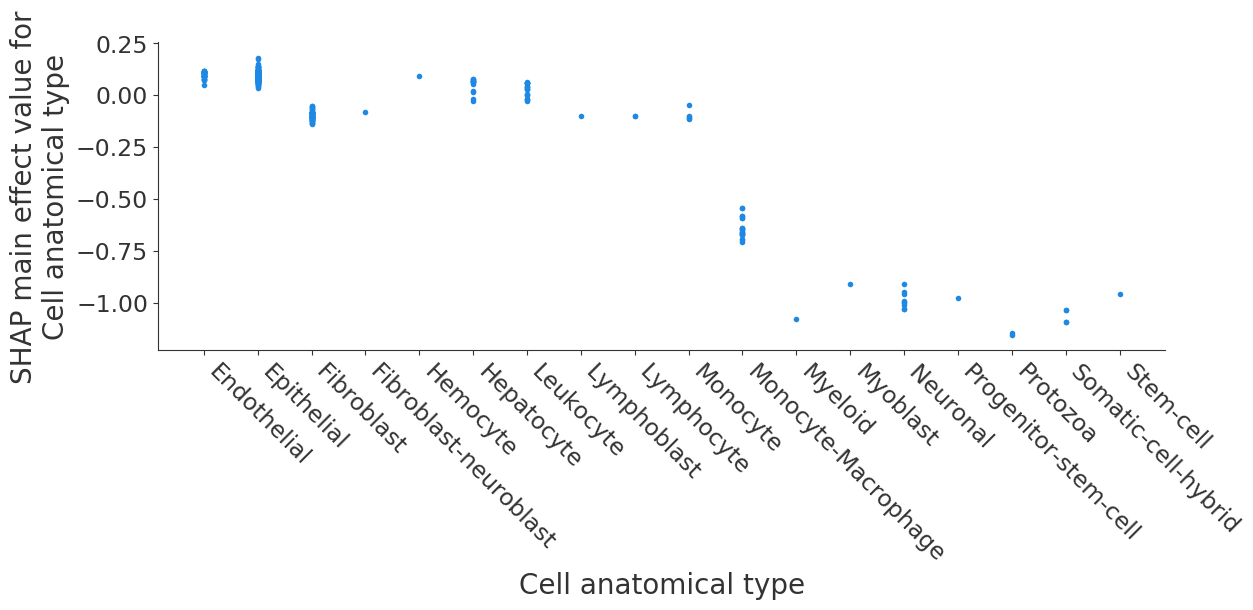

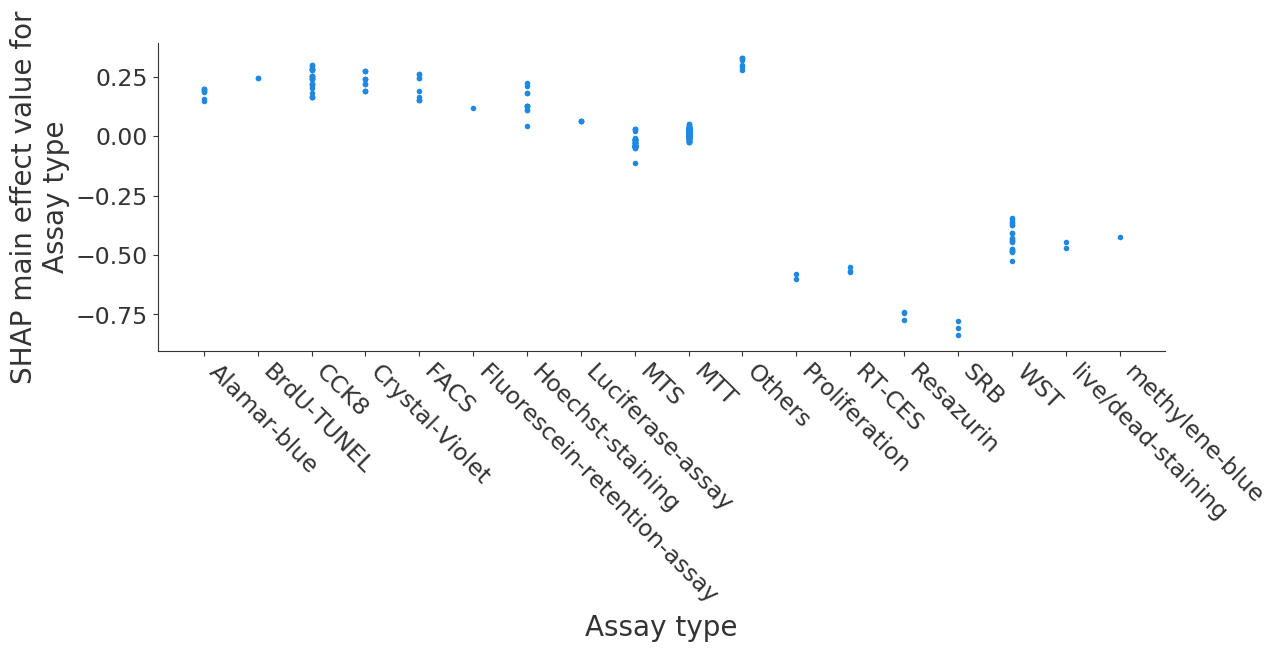

In [51]:
plt.style.use('default')
for feature in ['Cell anatomical type','Assay type']:
    
    fig, ax = plt.subplots()
    fig.set_size_inches(13, 4, forward=True)
    shap.dependence_plot((feature, feature), shap_interaction_values, select_X, show=False,display_features=display_dataset, ax=ax)
    
    if feature in Category_feature:
        category_num = max(select_X.loc[:,feature])+1
        xtickslabel = []
        for i in range(category_num):
            xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature]==i)][0],feature])
        ax.set_xticks(range(0,category_num))
        ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')    
        
    fig.savefig("./Result_fig_IC50_LightGBM/Main_effects_%s.jpg"%(feature),dpi=300,bbox_inches='tight')   

In [52]:
40.46/514

0.07871595330739299

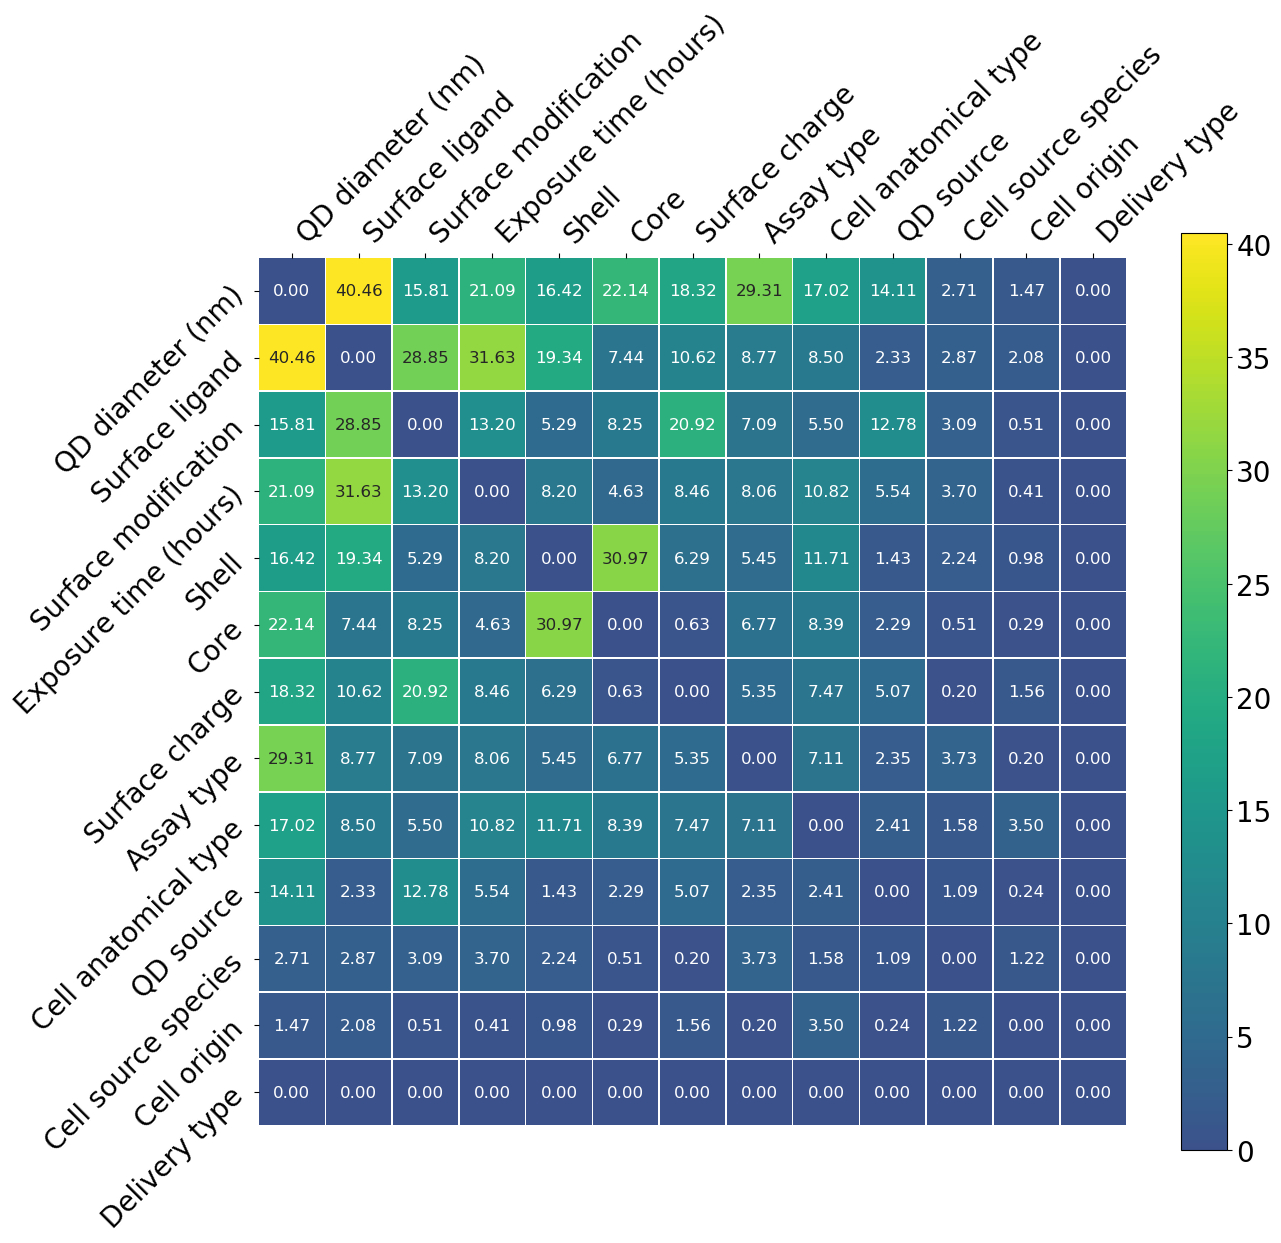

In [53]:
fig, ax= plt.subplots(figsize = (14, 14))
plt.style.use('default')
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
df_temp2 = pd.DataFrame(tmp2)
df_temp2.columns = select_X.columns[inds]
df_temp2.index = select_X.columns[inds]

h=sns.heatmap(df_temp2, cmap='viridis', square=True, center=df_temp2.iloc[0,1]/3,
            fmt=".2f", annot=True, linewidths=0.4, ax=ax, cbar=False,annot_kws={'size':12})
cb = h.figure.colorbar(h.collections[0],shrink=0.85) #显示colorbar
cb.ax.tick_params(labelsize=20)  # 设置colorbar刻度字体大小。
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,horizontalalignment='left',fontsize=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=45,horizontalalignment='right',fontsize=20)

fig.savefig("./Result_fig_IC50_LightGBM/Feature_interaction_summary_heatmap.jpg",dpi=300,bbox_inches='tight')

In [54]:
np.array(shap_interaction_values).shape

(514, 13, 13)

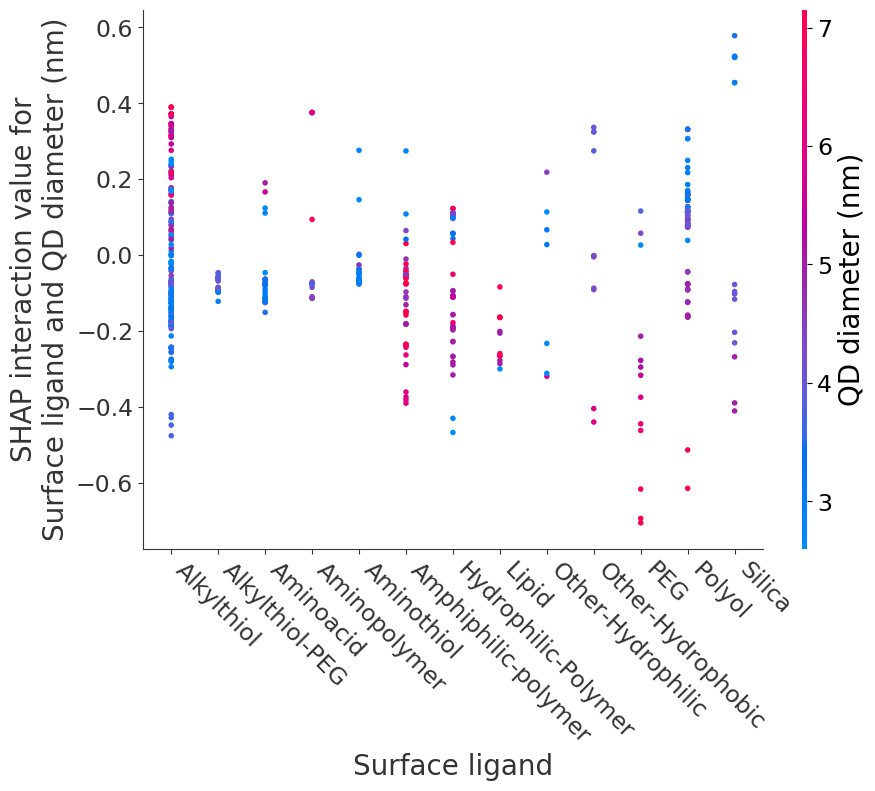

In [55]:
fig, ax = plt.subplots(figsize=(10, 7))
feature1 = 'Surface ligand'
feature2 = "QD diameter (nm)"
shap.dependence_plot((feature1, feature2),shap_interaction_values,select_X,ax=ax,show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
        
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

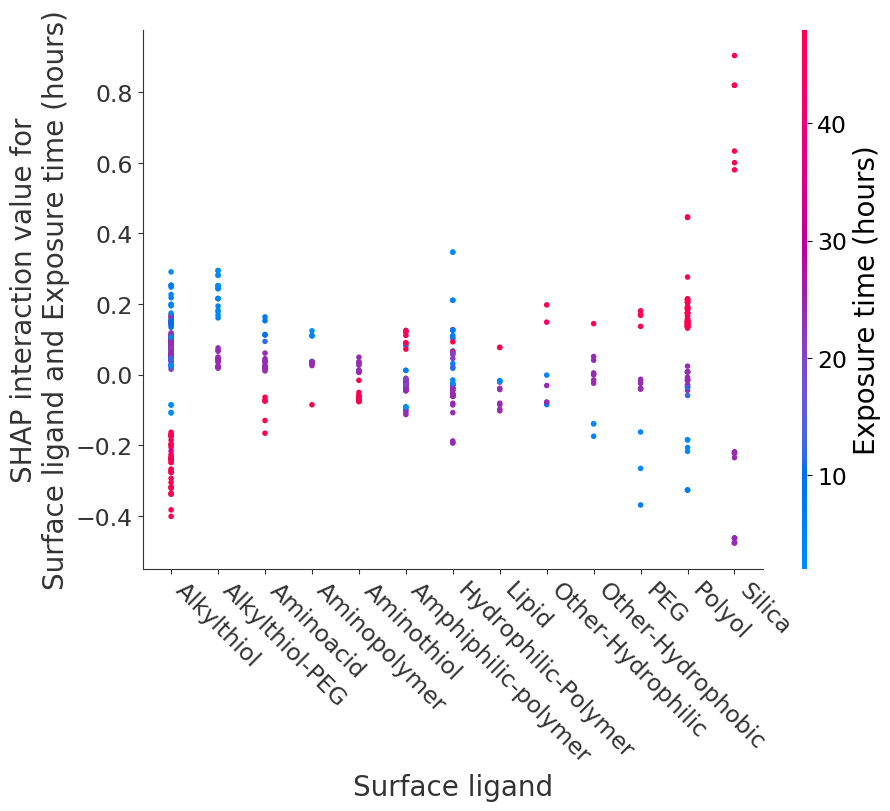

In [56]:
fig, ax = plt.subplots(figsize=(10, 7))
feature1 = 'Surface ligand'
feature2 = 'Exposure time (hours)'
shap.dependence_plot((feature1, feature2),shap_interaction_values,select_X,ax=ax,show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
        
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

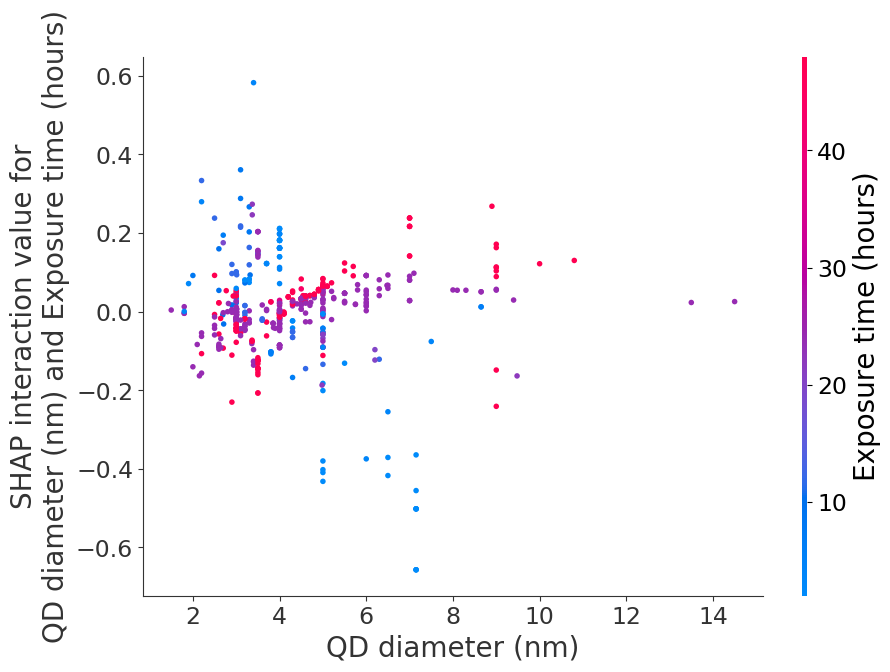

In [57]:
fig, ax = plt.subplots(figsize=(10, 7))
feature1 = 'QD diameter (nm)'
feature2 = 'Exposure time (hours)'
shap.dependence_plot((feature1, feature2),shap_interaction_values,select_X,ax=ax,show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
        
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

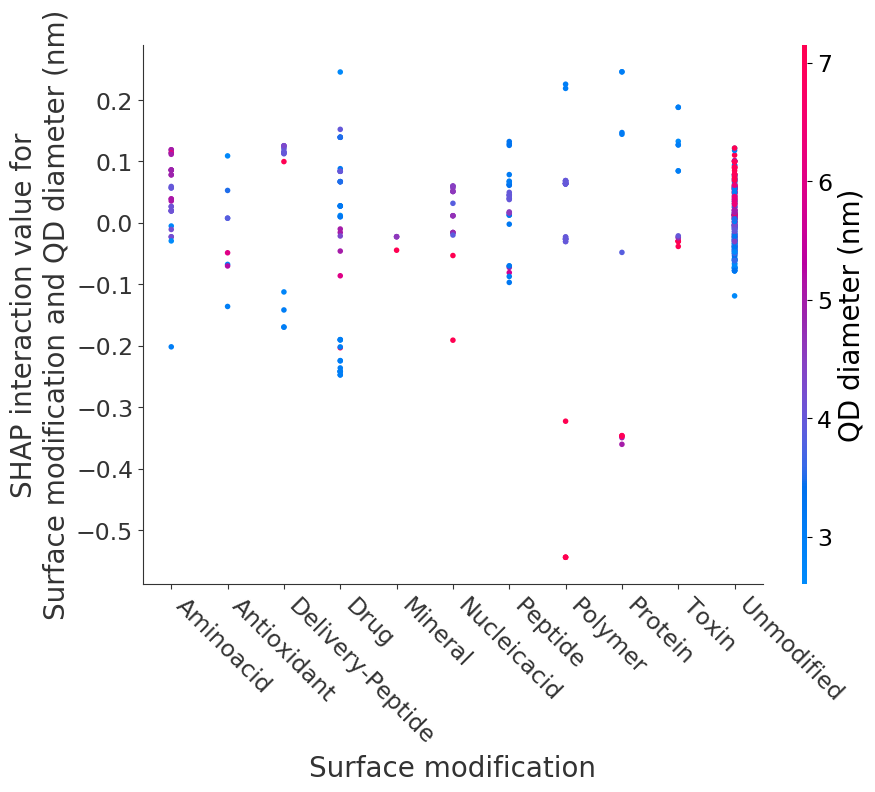

In [58]:
feature1 = 'Surface modification'
feature2 = 'QD diameter (nm)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

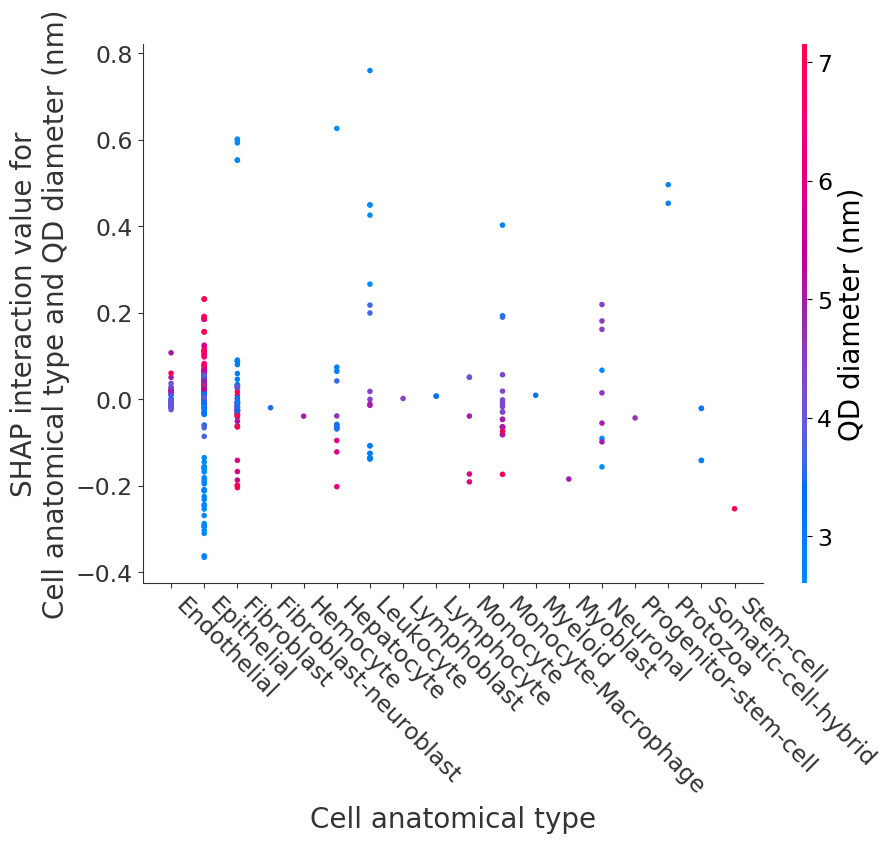

In [59]:
feature1 = 'Cell anatomical type'
feature2 = 'QD diameter (nm)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

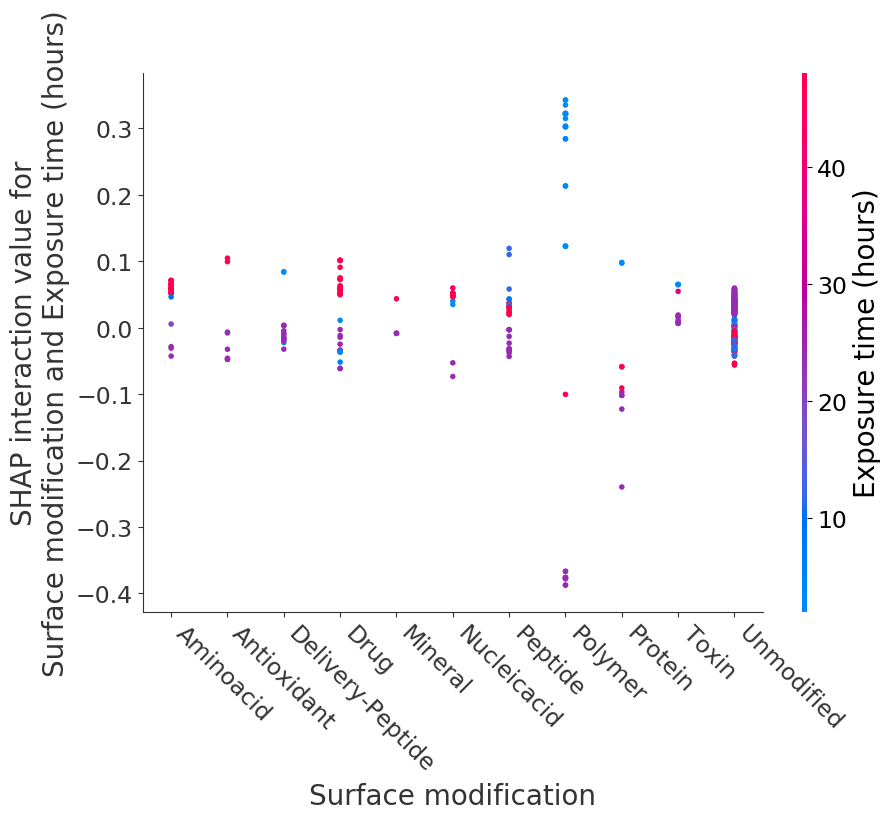

In [60]:
feature1 = 'Surface modification'
feature2 = 'Exposure time (hours)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

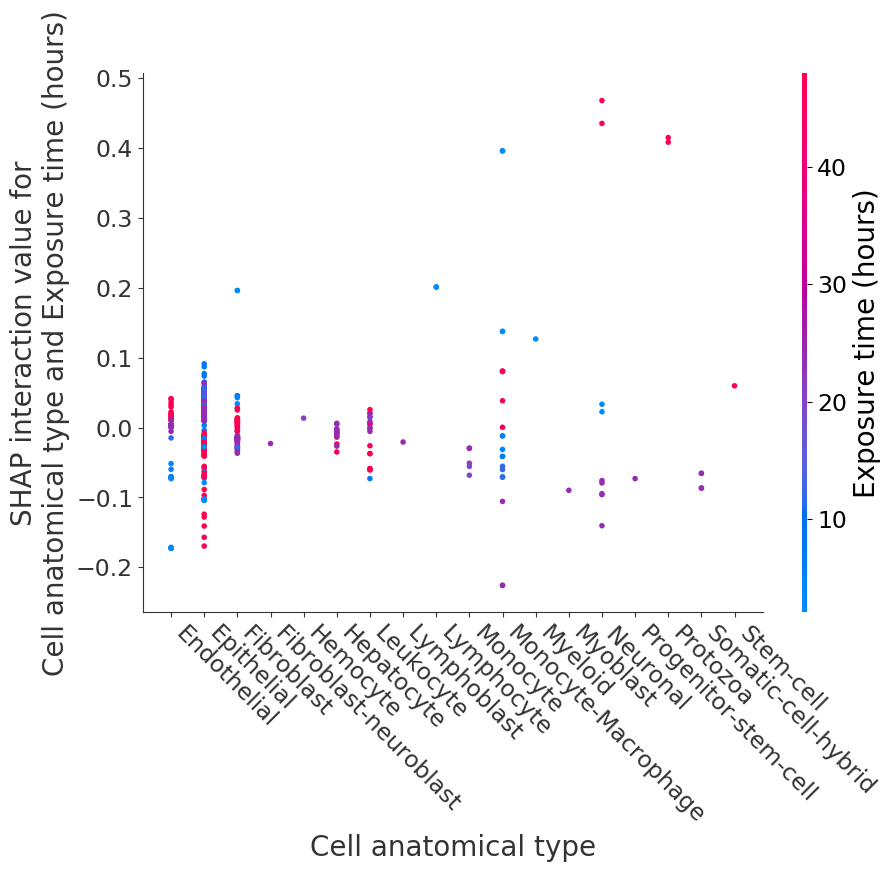

In [61]:
feature1 = 'Cell anatomical type'
feature2 = 'Exposure time (hours)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

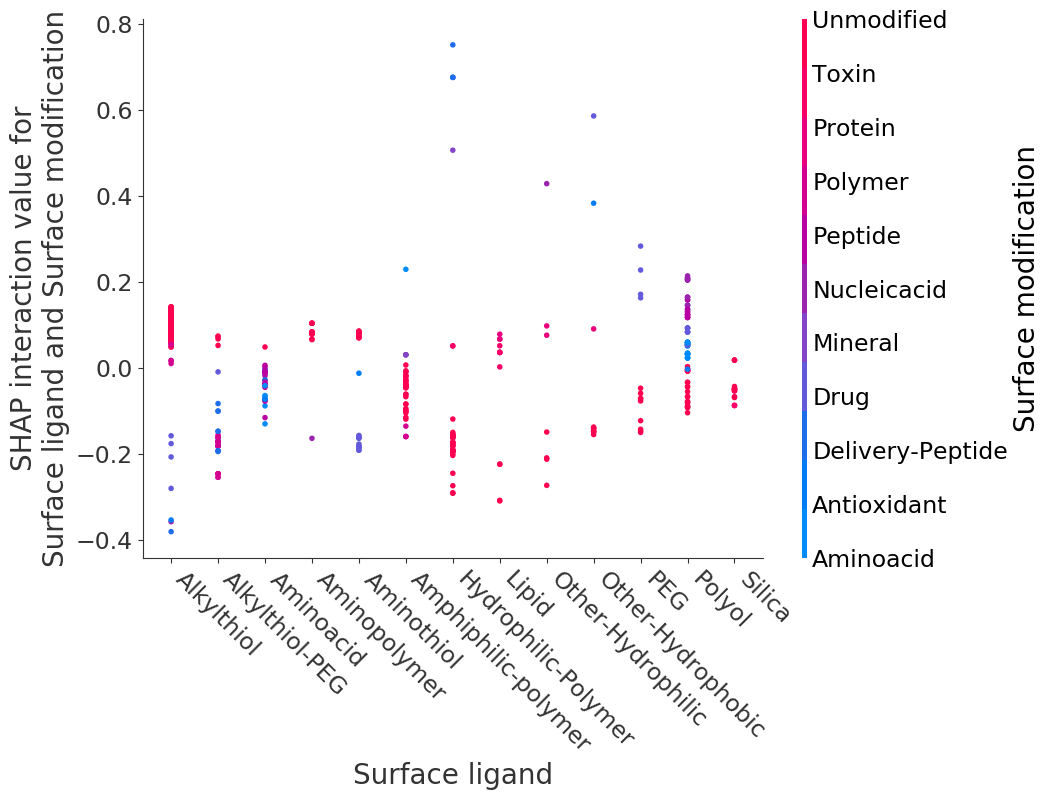

In [62]:
feature1 = 'Surface ligand'
feature2 = 'Surface modification'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

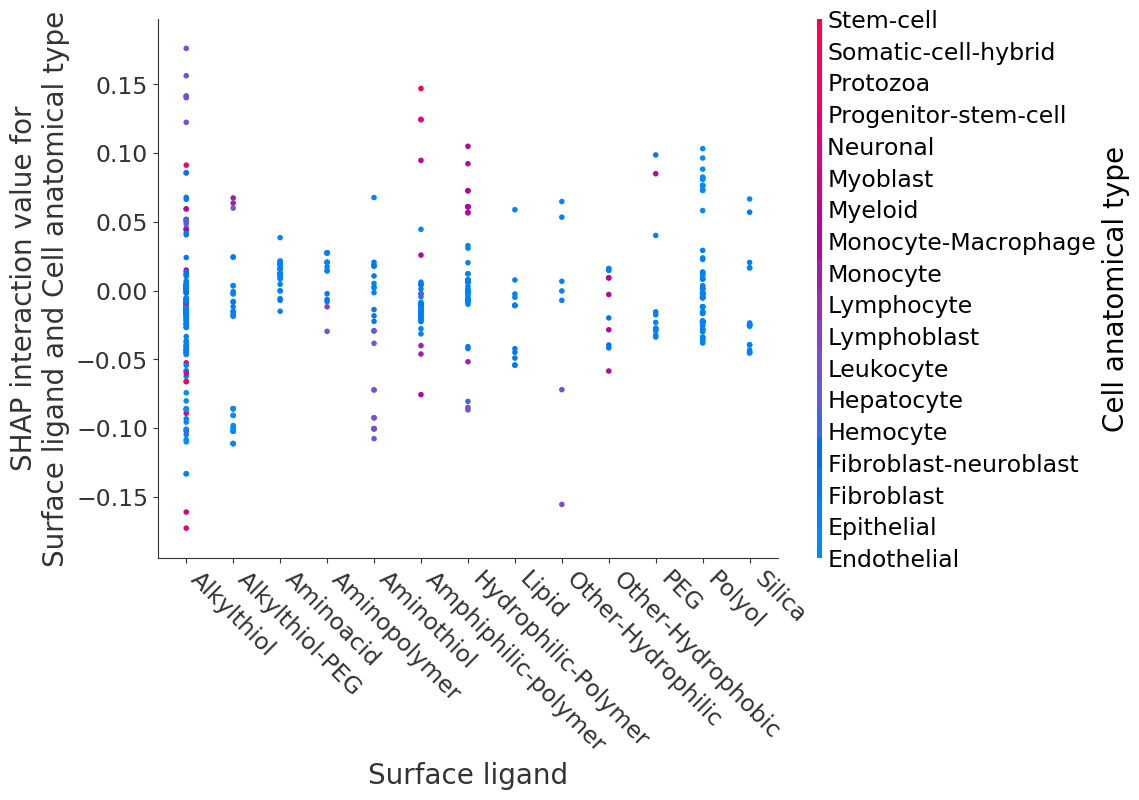

In [63]:
feature1 = 'Surface ligand'
feature2 = 'Cell anatomical type'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

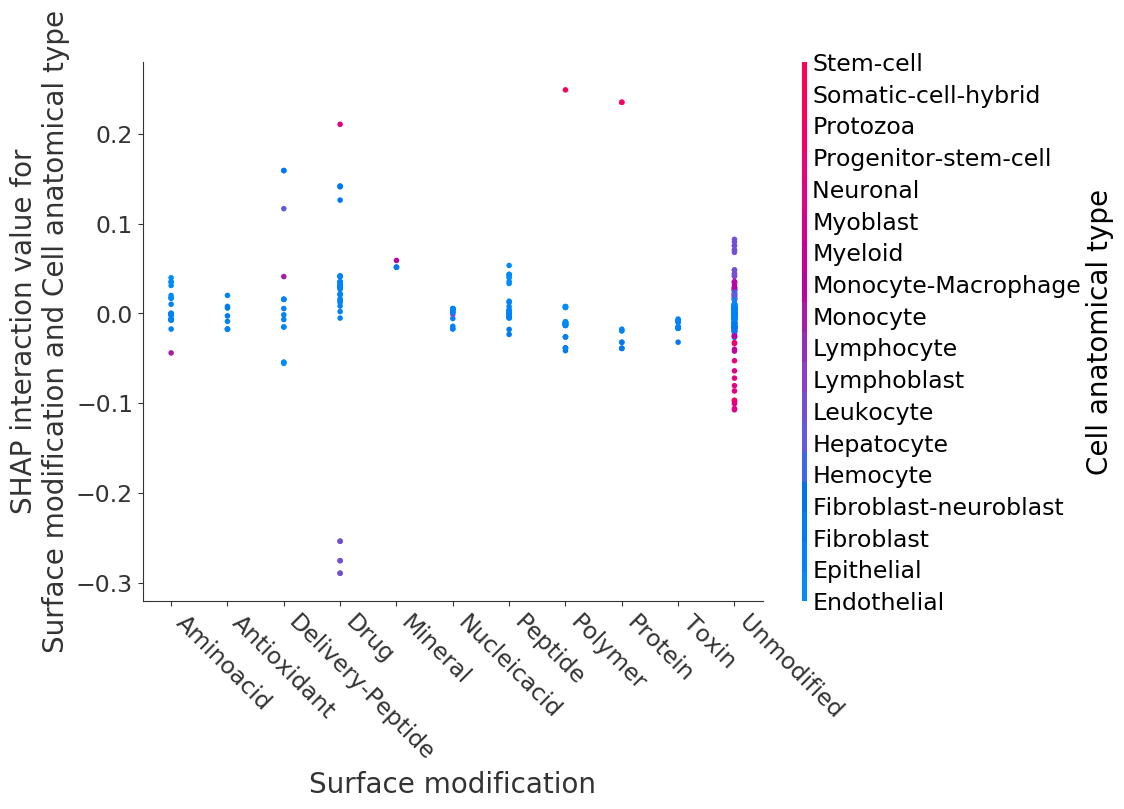

In [64]:
feature1 = 'Surface modification'
feature2 = 'Cell anatomical type'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')

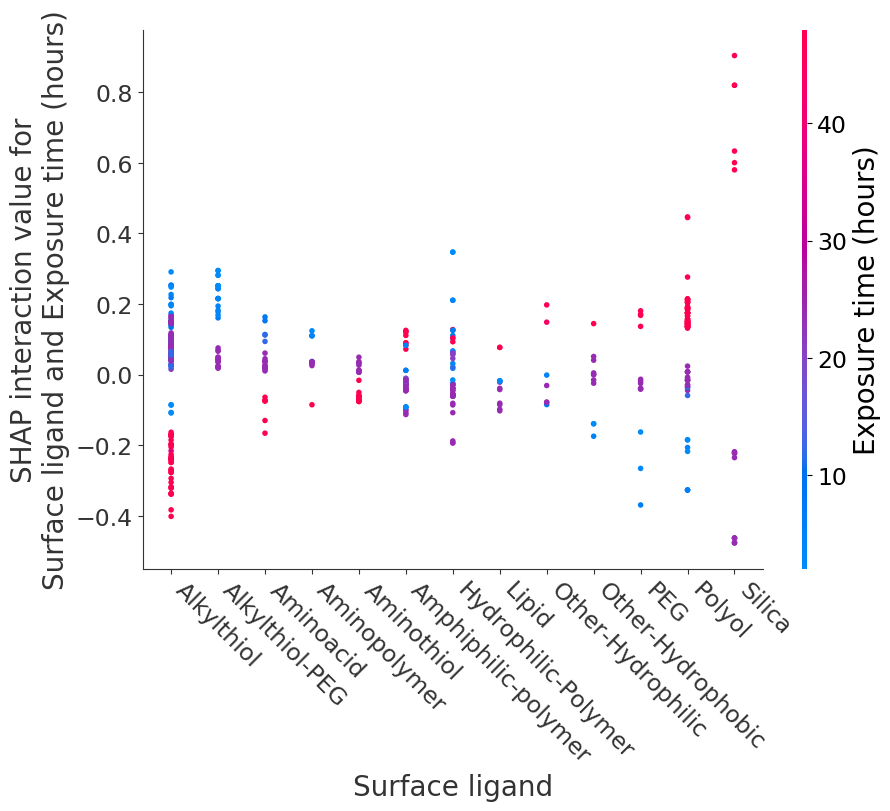

In [65]:
feature1 = 'Surface ligand'
feature2 ='Exposure time (hours)'
fig, ax = plt.subplots(figsize=(10, 7))
plt.style.use('default')
shap.dependence_plot((feature1, feature2), shap_interaction_values, select_X,ax=ax, show=False,display_features=display_dataset)

if feature1 in Category_feature:
    category_num = max(select_X.loc[:,feature1])+1
    xtickslabel = []
    for i in range(category_num):
        xtickslabel.append(X_display.loc[random_index[np.where(select_X.loc[:,feature1]==i)][0],feature1])
    ax.set_xticks(range(0,category_num))
    ax.set_xticklabels(xtickslabel,rotation=-45,ha ='left')
    
fig.savefig("./Result_fig_IC50_LightGBM/Interaction_plot_%s_%s.jpg"%(feature1,feature2),dpi=300,bbox_inches='tight')